In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from scipy.special import digamma, logsumexp
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)  # For reproducibility
plt.style.use('seaborn-v0_8')  # Updated style
sns.set_palette("deep")
print("Environment setup complete!")


Environment setup complete!


[*********************100%***********************]  5 of 5 completed


Data shape: (1760, 5)


<Figure size 1400x600 with 0 Axes>

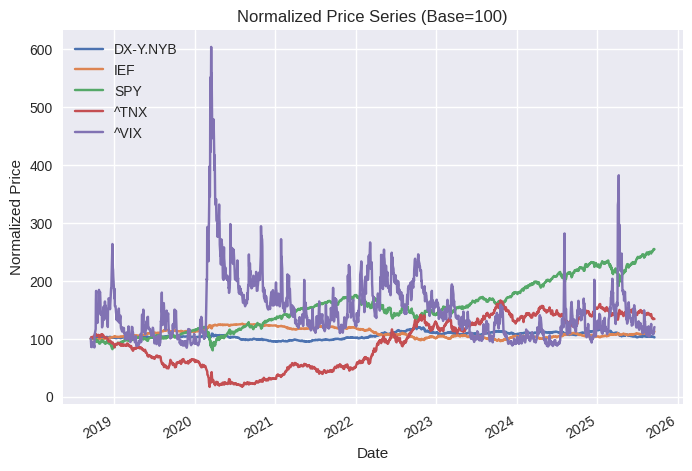

In [2]:
portfolio_tickers = ["SPY", "IEF"]
risk_factor_tickers = ["^VIX", "^TNX", "DX-Y.NYB"]
tickers = portfolio_tickers + risk_factor_tickers

end = pd.Timestamp.today()
start = end - pd.DateOffset(years=7)  # Extended to 7 years

print("Downloading financial data...")
try:
    prices = yf.download(tickers, start=start, end=end)['Close'].dropna()
    print(f"Data shape: {prices.shape}")
except Exception as e:
    print(f"Error downloading data: {e}")
    # Implement fallback or raise error

# Plot normalized price series
plt.figure(figsize=(14, 6))
(prices / prices.iloc[0] * 100).plot()
plt.title('Normalized Price Series (Base=100)')
plt.ylabel('Normalized Price')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.show()

In [3]:
features = pd.DataFrame(index=prices.index)
features['TNX_1d'] = prices['^TNX'].pct_change()
features['VIX_5d'] = prices['^VIX'].pct_change(5)
features['DXY_vol5d'] = prices['DX-Y.NYB'].pct_change().rolling(5).std()
features['TNX_5d'] = prices['^TNX'].pct_change(5)
features['DXY_10d'] = prices['DX-Y.NYB'].pct_change(10)

# --- FINE-TUNED: ADDITIONAL FEATURES ---
features['VIX_1d'] = prices['^VIX'].pct_change()  # Short-term VIX
features['VIX_TNX_5d_ratio'] = features['VIX_5d'] / (features['TNX_5d'] + 1e-8)  # Interaction
features['DXY_TNX_corr_10d'] = prices['DX-Y.NYB'].rolling(10).corr(prices['^TNX'])  # Rolling correlation

features = features.dropna()
print(f"Feature matrix shape: {features.shape}")

scaler = StandardScaler()
features_z = pd.DataFrame(
    scaler.fit_transform(features),
    index=features.index,
    columns=[c + '_z' for c in features.columns]
)
print("Standardized features:")
print(features_z.head())

Feature matrix shape: (1750, 8)
Standardized features:
            TNX_1d_z  VIX_5d_z  DXY_vol5d_z  TNX_5d_z  DXY_10d_z  VIX_1d_z  \
Date                                                                         
2018-10-01  0.205098 -0.170562    -0.044035 -0.035702   0.624071 -0.157819   
2018-10-02 -0.246187 -0.244697    -0.330921 -0.266466   0.704801  0.008257   
2018-10-03  0.969624 -0.629346    -0.454662  0.441652   0.966267 -0.472005   
2018-10-04  0.307075  0.727233    -1.461082  0.642463   1.490196  2.613018   
2018-10-05  0.231196  1.152891    -1.165051  0.779057   1.125195  0.457189   

            VIX_TNX_5d_ratio_z  DXY_TNX_corr_10d_z  
Date                                                
2018-10-01            0.017412           -1.205881  
2018-10-02            0.017470           -1.470141  
2018-10-03            0.017459            0.048837  
2018-10-04            0.017472            0.489128  
2018-10-05            0.017474            0.566488  


Portfolio P&L statistics:
count     1759.000000
mean       473.770309
std       9137.137608
min     -58943.350543
25%      -3540.740600
50%        766.673687
75%       5114.845665
max      98653.223273
Name: Total_Value, dtype: float64


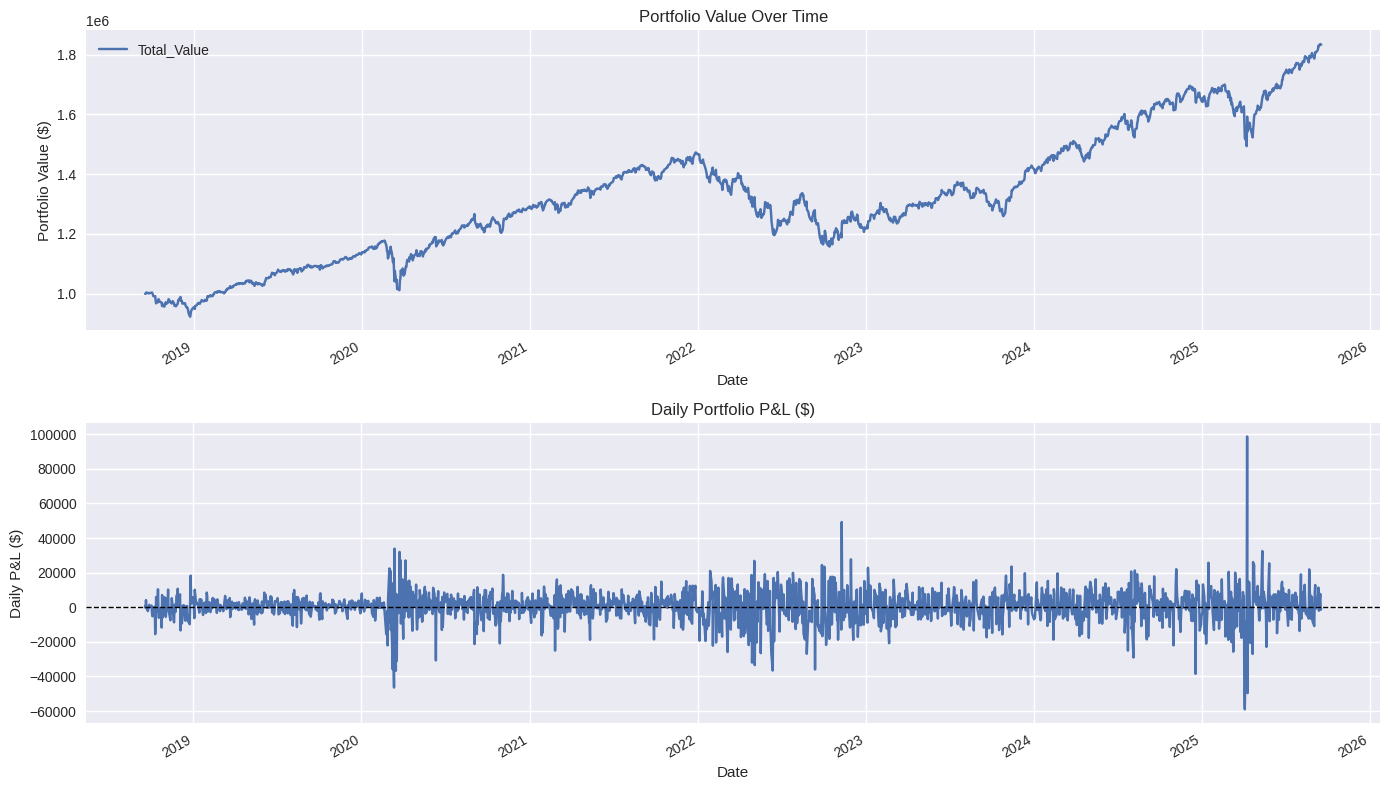

In [4]:
w_spy, w_ief = 0.5, 0.5
portfolio_value = 1000000.0  # Fine-tuned: $1 Million portfolio

spy_nav = w_spy * portfolio_value * prices['SPY'] / prices['SPY'].iloc[0]
ief_nav = w_ief * portfolio_value * prices['IEF'] / prices['IEF'].iloc[0]
total_nav = (spy_nav + ief_nav).to_frame('Total_Value')

portfolio_ret = total_nav.pct_change().iloc[1:]
portfolio_pnl = total_nav['Total_Value'].diff()

print("Portfolio P&L statistics:")
print(portfolio_pnl.describe())

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
total_nav.plot(ax=ax1)
ax1.set_title('Portfolio Value Over Time')
ax1.set_ylabel('Portfolio Value ($)')

portfolio_pnl.plot(ax=ax2)
ax2.axhline(y=0, color='k', linestyle='--', linewidth=1)
ax2.set_title('Daily Portfolio P&L ($)')
ax2.set_ylabel('Daily P&L ($)')
ax2.set_xlabel('Date')
plt.tight_layout()
plt.show()

In [5]:
D_horizon = 10
lookback = 250

def hist_ret_vector_as_of(end_dt, prices_df, D, T):
    idx = prices_df.index
    loc = idx.get_loc(end_dt)
    starts = [loc - D - k for k in range(T)]
    ends = [s + D for s in starts]
    rets = prices_df.iloc[starts].values / prices_df.iloc[ends].values - 1.0
    pnl = (w_spy * rets[:, 0] + w_ief * rets[:, 1]) * portfolio_value
    return pnl

historical_sim_vectors = pd.DataFrame(index=prices.index, columns=range(lookback))
first_valid = lookback + D_horizon

for t in range(first_valid, len(prices)):
    end_date = prices.index[t]
    historical_sim_vectors.loc[end_date] = hist_ret_vector_as_of(
        end_date, prices[['SPY', 'IEF']], D_horizon, lookback
    )

historical_sim_vectors = historical_sim_vectors.dropna().astype(float)
print(f"Historical simulation matrix shape: {historical_sim_vectors.shape}")

Historical simulation matrix shape: (1500, 250)


In [6]:
rolling_mean = historical_sim_vectors.mean(axis=1)
rolling_std = historical_sim_vectors.std(axis=1)

category_assignments = pd.DataFrame(
    index=historical_sim_vectors.index,
    columns=historical_sim_vectors.columns,
    dtype=int
)

for t_date in historical_sim_vectors.index:
    mu = rolling_mean.loc[t_date]
    sigma = rolling_std.loc[t_date]
    z_vec = (historical_sim_vectors.loc[t_date] - mu) / sigma

    # --- FINE-TUNED: Use Quantiles Instead of Fixed Z ---
    cats = np.full_like(z_vec, 2, dtype=int)  # Default: Neutral
    lower_quantile = np.percentile(z_vec, 30)  # Bottom 30%
    upper_quantile = np.percentile(z_vec, 70)  # Top 30%
    cats[z_vec < lower_quantile] = 1  # Big Loss
    cats[z_vec > upper_quantile] = 3  # Big Gain

    category_assignments.loc[t_date] = cats

common_dates = features_z.index.intersection(category_assignments.index)
features_z_aligned = features_z.loc[common_dates]
category_assignments_aligned = category_assignments.loc[common_dates]
historical_sim_vectors_aligned = historical_sim_vectors.loc[common_dates]

print(f"Aligned datasets: {len(common_dates)}")
print(f"Features shape: {features_z_aligned.shape}")
print(f"Category assignments shape: {category_assignments_aligned.shape}")
print(f"Historical simulation shape: {historical_sim_vectors_aligned.shape}")

Aligned datasets: 1500
Features shape: (1500, 8)
Category assignments shape: (1500, 250)
Historical simulation shape: (1500, 250)


In [7]:
# Prepare data for VI
Xs = features_z_aligned.values.astype(float)
dts = category_assignments_aligned.iloc[:, 0].values.astype(int) - 1  # Use first column
J = 3  # Number of categories

# Function to run CAVI and return ELBO
def run_cavi_once(K):
    """Run CAVI and return final ELBO for given K."""
    # Hyperparameters
    n_features = Xs.shape[1]
    pi_prior = np.ones(K) / K
    mu_k0_prior = np.mean(Xs, axis=0)
    R_k0_prior = np.eye(n_features) * 10
    alpha_k_prior = np.ones(J)
    M_matrix = np.cov(Xs, rowvar=False)
    M_inv = np.linalg.inv(M_matrix)

    # Initialize variational parameters
    T, n_features = Xs.shape
    phi = np.full((T, K), 1.0 / K)
    mu_hat = Xs[np.random.choice(T, size=K, replace=False)]
    R_hat = np.tile(R_k0_prior, (K, 1, 1))
    alpha_hat = np.tile(alpha_k_prior, (K, 1))

    # CAVI loop
    for it in range(200):
        phi_prev = phi.copy()

        # Update phi
        log_pi = np.log(pi_prior + 1e-32)
        digamma_alpha = digamma(alpha_hat)
        digamma_sum_alpha = digamma(alpha_hat.sum(axis=1, keepdims=True))
        log_phi = np.zeros((T, K))
        log_pi = np.log(pi_prior + 1e-10)

        for k in range(K):
            log_term1 = log_pi[k]
            trace_term = np.trace(M_inv @ (np.outer(mu_hat[k], mu_hat[k]) + R_hat[k]))
            log_term2 = Xs @ (M_inv @ mu_hat[k]) - 0.5 * trace_term
            digamma_term = digamma_alpha[k, dts] - digamma_sum_alpha[k]
            log_phi[:, k] = log_term1 + log_term2 + digamma_term

        log_phi -= np.array([logsumexp(log_phi, axis=1)]).T
        phi = np.exp(log_phi)

        # Update other parameters
        Nk = phi.sum(axis=0)
        Rk0_inv = np.linalg.inv(R_k0_prior)

        for k in range(K):
            S_k = Rk0_inv + M_inv * Nk[k]
            R_hat[k] = np.linalg.inv(S_k)
            weighted_sum_x = (phi[:, k][:, None] * Xs).sum(axis=0)
            mu_hat[k] = R_hat[k] @ (Rk0_inv @ mu_k0_prior + M_inv @ weighted_sum_x)
            alpha_hat[k] = alpha_k_prior + (phi[:, k][:, None] * np.eye(J)[dts]).sum(axis=0)

        if np.max(np.abs(phi - phi_prev)) < 1e-6:
            break

    # Calculate ELBO (simplified)
    elbo = 0.0
    for k in range(K):
        for t in range(T):
            elbo += phi[t, k] * (
                np.log(pi_prior[k] + 1e-32) +
                Xs[t] @ (M_inv @ mu_hat[k]) - 0.5 * np.trace(M_inv @ (np.outer(mu_hat[k], mu_hat[k]) + R_hat[k])) +
                digamma_alpha[k, dts[t]] - digamma_sum_alpha[k]
            )
    return elbo

# Grid search for optimal K
Ks_grid = range(2, 7)
elbo_scores = []

print("Running ELBO grid search for optimal K...")
for k in Ks_grid:
    elbo = run_cavi_once(k)
    elbo_scores.append(elbo)
    print(f"K={k}, ELBO={elbo}")

best_K = Ks_grid[np.argmax(elbo_scores)]
print(f"\nOptimal K: {best_K}")

Running ELBO grid search for optimal K...
K=2, ELBO=[-1891.14016736]
K=3, ELBO=[-1761.30086196]
K=4, ELBO=[-2249.20903259]
K=5, ELBO=[-2528.25978799]
K=6, ELBO=[-2542.72383648]

Optimal K: 3


In [8]:
from sklearn.cluster import KMeans
# Set optimal K
K = best_K
kmeans_init = KMeans(n_clusters=K, random_state=42, n_init=10)
kmeans_labels = kmeans_init.fit_predict(features_z_aligned.values)
mu_hat_k = kmeans_init.cluster_centers_

# Hyperparameters
n_features = features_z_aligned.shape[1]
pi_prior = np.ones(K) / K
mu_k0_prior = np.mean(features_z_aligned.values, axis=0)
R_k0_prior = np.eye(n_features) * 10
alpha_k_prior = np.ones(J)
M_matrix = np.cov(features_z_aligned.values, rowvar=False)
M_inv = np.linalg.inv(M_matrix)

# Initialize variational parameters
T, n_features = features_z_aligned.shape
phi_tk = np.random.rand(T, K)
phi_tk = phi_tk / phi_tk.sum(axis=1, keepdims=True)
mu_hat_k = features_z_aligned.values[np.random.choice(T, size=K, replace=False)]
R_hat_k = np.tile(R_k0_prior, (K, 1, 1))
alpha_hat_k = np.tile(alpha_k_prior, (K, 1))

print("Starting CAVI training...")
# CAVI loop
for iteration in range(200):
    phi_prev = phi_tk.copy()

    # Update phi
    log_pi = np.log(pi_prior + 1e-32)
    digamma_alpha = digamma(alpha_hat_k)
    digamma_sum_alpha = digamma(alpha_hat_k.sum(axis=1, keepdims=True))
    log_phi = np.zeros((T, K))

    for k in range(K):
        log_term1 = log_pi[k]
        trace_term = np.trace(M_inv @ (np.outer(mu_hat_k[k], mu_hat_k[k]) + R_hat_k[k]))
        log_term2 = features_z_aligned.values @ (M_inv @ mu_hat_k[k]) - 0.5 * trace_term
        digamma_term = digamma_alpha[k, dts] - digamma_sum_alpha[k]
        log_phi[:, k] = log_term1 + log_term2 + digamma_term

    log_phi -= np.array([logsumexp(log_phi, axis=1)]).T
    phi_tk = np.exp(log_phi)

    # Update other parameters
    Nk = phi_tk.sum(axis=0)
    Rk0_inv = np.linalg.inv(R_k0_prior)

    for k in range(K):
        S_k = Rk0_inv + M_inv * Nk[k]
        R_hat_k[k] = np.linalg.inv(S_k)
        weighted_sum_x = (phi_tk[:, k][:, None] * features_z_aligned.values).sum(axis=0)
        mu_hat_k[k] = R_hat_k[k] @ (Rk0_inv @ mu_k0_prior + M_inv @ weighted_sum_x)
        alpha_hat_k[k] = alpha_k_prior + (phi_tk[:, k][:, None] * np.eye(J)[dts]).sum(axis=0)

    # Check convergence
    if np.max(np.abs(phi_tk - phi_prev)) < 1e-6:
        print(f"Converged at iteration {iteration}")
        break

print("VI model training complete!")
print(f"Final cluster probabilities shape: {phi_tk.shape}")
print(f"Cluster means shape: {mu_hat_k.shape}")
print(f"Cluster covariances shape: {R_hat_k.shape}")
print(f"Category parameters shape: {alpha_hat_k.shape}")

Starting CAVI training...
Converged at iteration 142
VI model training complete!
Final cluster probabilities shape: (1500, 3)
Cluster means shape: (3, 8)
Cluster covariances shape: (3, 8, 8)
Category parameters shape: (3, 3)


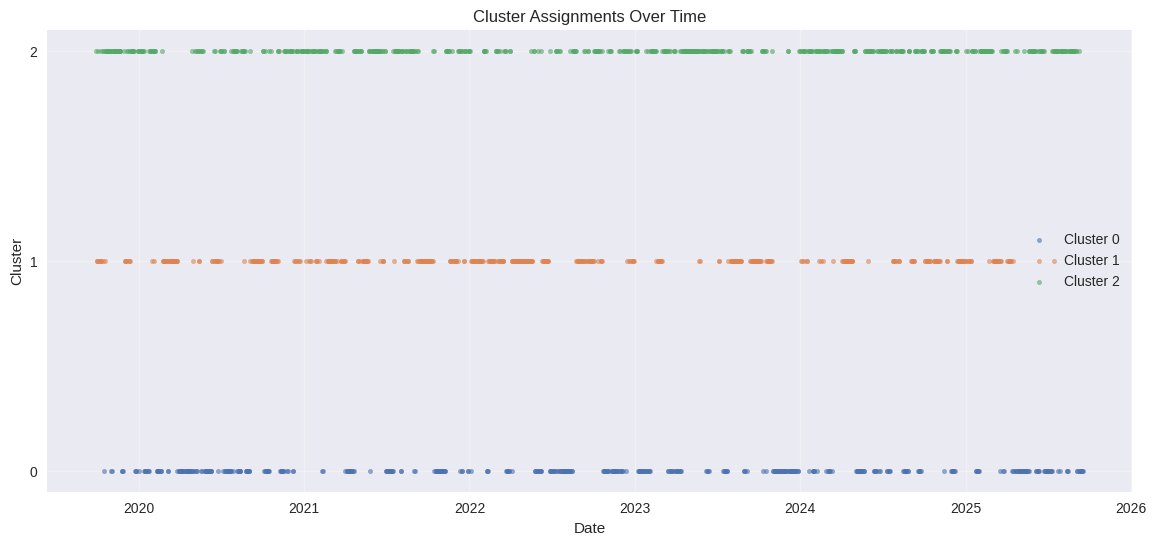

Cluster distribution:
Cluster
0    449
1    453
2    598
Name: count, dtype: int64


In [9]:
dominant_cluster = np.argmax(phi_tk, axis=1)
cluster_df = pd.DataFrame({
    'Date': features_z_aligned.index,
    'Cluster': dominant_cluster
}).set_index('Date')

plt.figure(figsize=(14, 6))
for k in range(K):
    cluster_data = cluster_df[cluster_df['Cluster'] == k]
    plt.scatter(cluster_data.index, cluster_data['Cluster'], label=f'Cluster {k}', alpha=0.6, s=10)
plt.title('Cluster Assignments Over Time')
plt.xlabel('Date')
plt.ylabel('Cluster')
plt.yticks(range(K))
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Cluster distribution:")
print(cluster_df['Cluster'].value_counts().sort_index())

Initializing SHAP explainer...
SHAP explainer initialized successfully
Computing SHAP values...


Computing SHAP values per cluster:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Computing SHAP values per cluster:  33%|███▎      | 1/3 [00:00<00:01,  1.48it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Computing SHAP values per cluster:  67%|██████▋   | 2/3 [00:01<00:00,  1.47it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Computing SHAP values per cluster: 100%|██████████| 3/3 [00:02<00:00,  1.35it/s]

SHAP values computed successfully
Generating SHAP visualizations...

Processing Cluster 0...


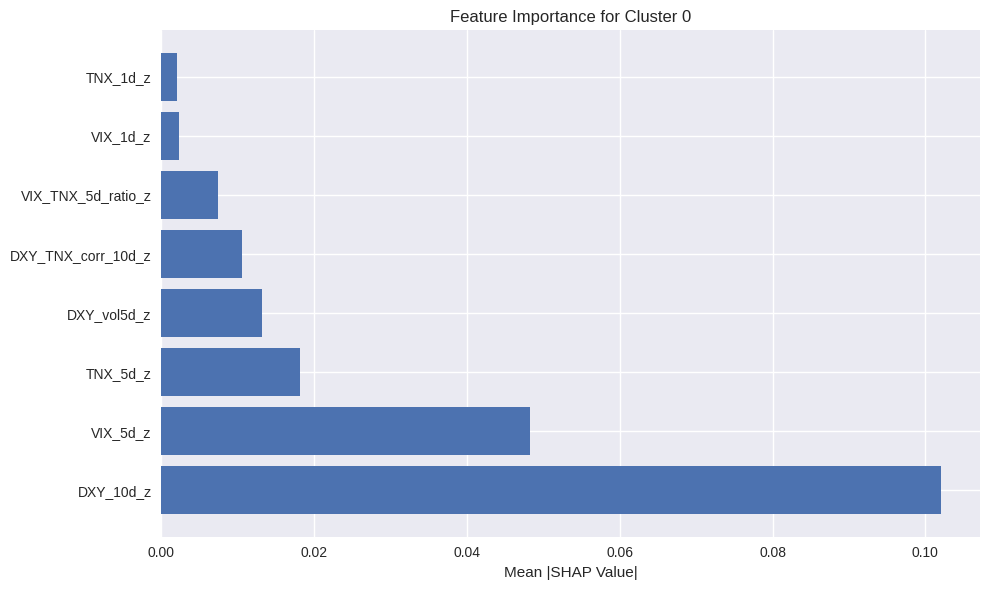

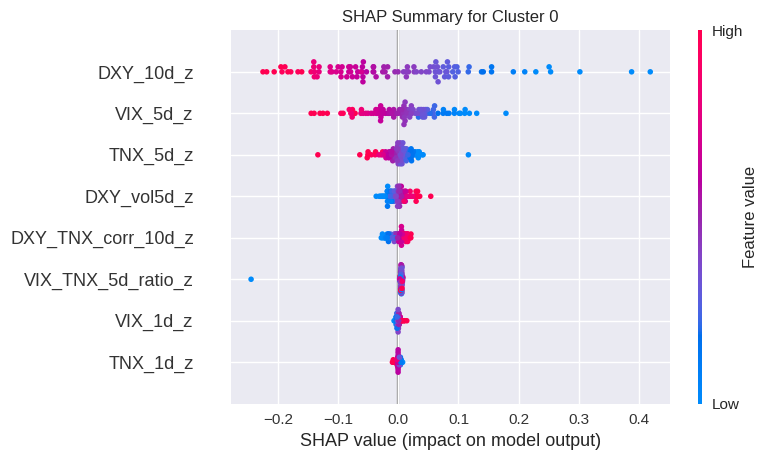

<Figure size 1000x600 with 0 Axes>

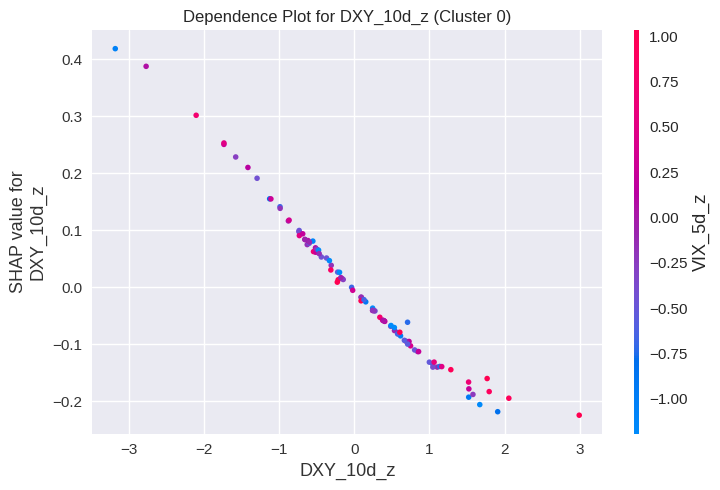


Processing Cluster 1...


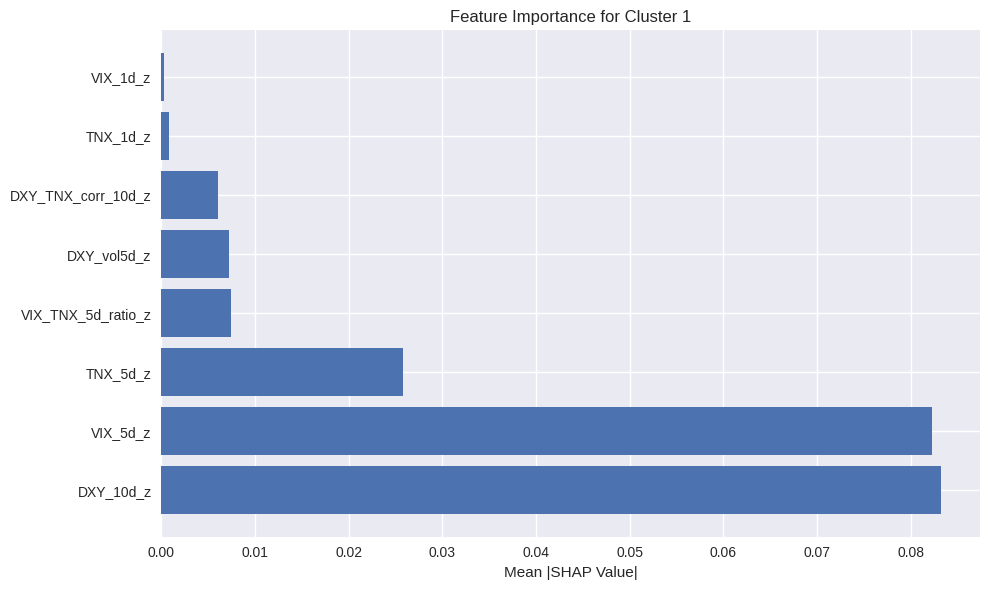

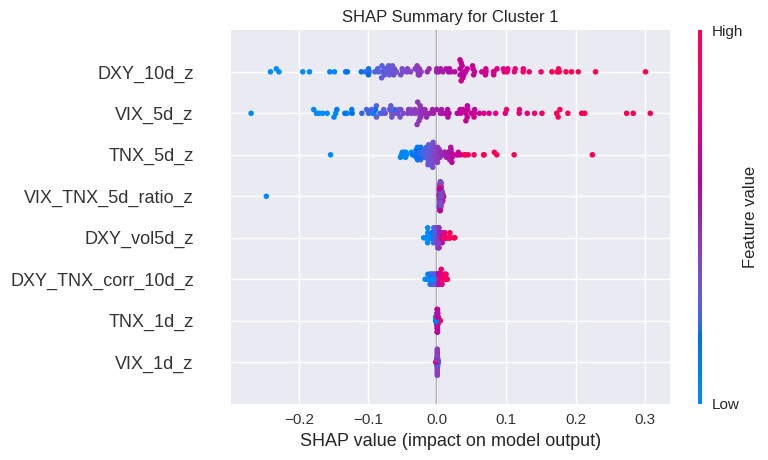

<Figure size 1000x600 with 0 Axes>

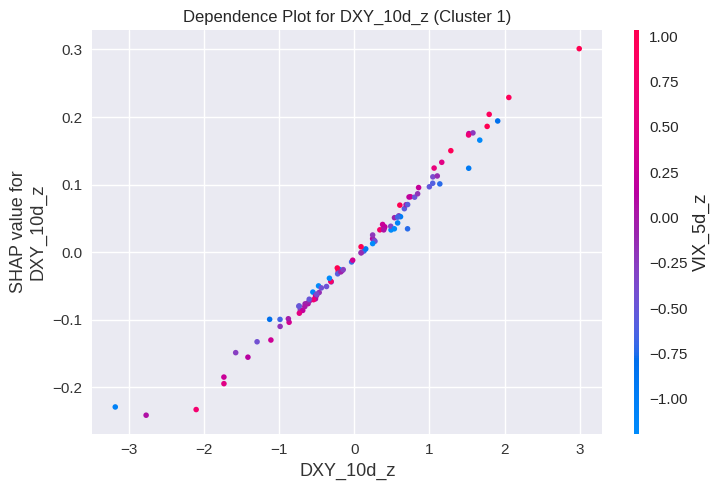


Processing Cluster 2...


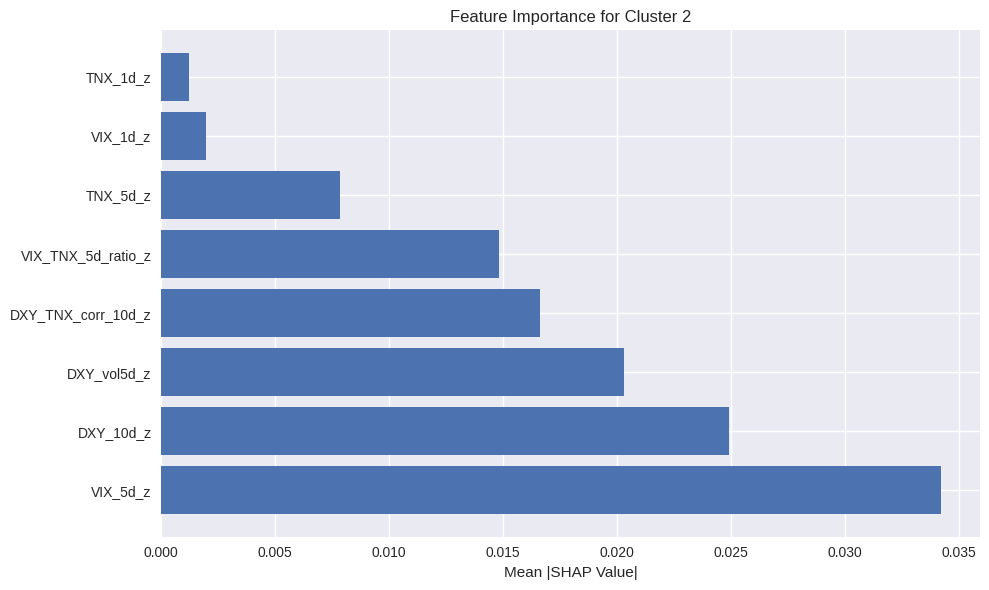

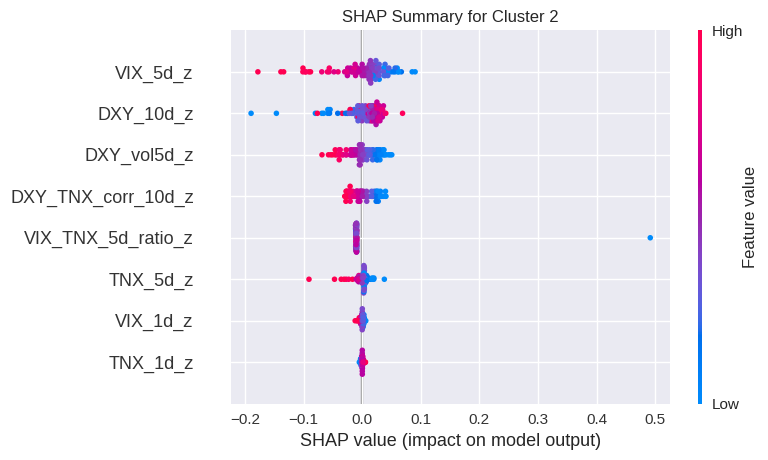

<Figure size 1000x600 with 0 Axes>

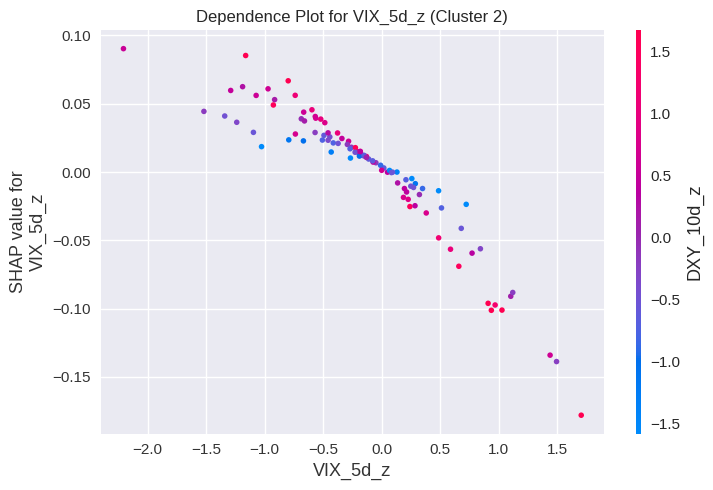


FEATURE IMPORTANCE SUMMARY

Cluster 0 (Top 5 Features):
----------------------------------------
1. DXY_10d_z      : 0.1021
2. VIX_5d_z       : 0.0483
3. TNX_5d_z       : 0.0181
4. DXY_vol5d_z    : 0.0131
5. DXY_TNX_corr_10d_z: 0.0106

Cluster 1 (Top 5 Features):
----------------------------------------
1. DXY_10d_z      : 0.0832
2. VIX_5d_z       : 0.0823
3. TNX_5d_z       : 0.0258
4. VIX_TNX_5d_ratio_z: 0.0074
5. DXY_vol5d_z    : 0.0073

Cluster 2 (Top 5 Features):
----------------------------------------
1. VIX_5d_z       : 0.0342
2. DXY_10d_z      : 0.0249
3. DXY_vol5d_z    : 0.0203
4. DXY_TNX_corr_10d_z: 0.0166
5. VIX_TNX_5d_ratio_z: 0.0148

SHAP analysis complete!


In [10]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Step 10.1: Create prediction function with error handling
def predict_cluster_proba(X):
    try:
        if isinstance(X, pd.DataFrame):
            X = X.values
        if X.ndim == 1:
            X = X.reshape(1, -1)
        if np.isnan(X).any():
            raise ValueError("Input contains NaN values")

        log_qpred = np.zeros((X.shape[0], K))
        for k in range(K):
            quad_k = -0.5 * np.trace(M_inv @ (np.outer(mu_hat_k[k], mu_hat_k[k]) + R_hat_k[k]))
            lin_term = M_inv @ mu_hat_k[k]  # Pre-compute this
            lin = X @ lin_term  # More efficient
            log_qpred[:, k] = np.log(pi_prior[k] + 1e-32) + lin + quad_k

        max_log = np.max(log_qpred, axis=1, keepdims=True)
        log_qpred -= max_log
        exp_log = np.exp(log_qpred)
        sum_exp = np.sum(exp_log, axis=1, keepdims=True)
        return exp_log / (sum_exp + 1e-32)
    except Exception as e:
        print(f"Error in predict_cluster_proba: {str(e)}")
        return np.ones((X.shape[0], K)) / K

# Step 10.2: Initialize SHAP explainer with error handling
print("Initializing SHAP explainer...")
try:
    # Use a smaller background sample for efficiency
    background_size = min(50, len(features_z_aligned))
    background_data = features_z_aligned.sample(background_size, random_state=42)

    # Create the explainer with specific settings
    explainer = shap.KernelExplainer(
        predict_cluster_proba,
        background_data,
        nsamples=100,  # Reduced for speed
        link="logit"   # Use logit link for probability outputs
    )
    print("SHAP explainer initialized successfully")
except Exception as e:
    print(f"Error initializing SHAP explainer: {str(e)}")
    raise

# Step 10.3: Compute SHAP values with progress tracking
print("Computing SHAP values...")
try:
    # Use a smaller sample for computation
    sample_size = min(100, len(features_z_aligned))
    sample_data = features_z_aligned.sample(sample_size, random_state=42)

    # Compute SHAP values with progress bar
    shap_values = []
    for i in tqdm(range(K), desc="Computing SHAP values per cluster"):
        # Compute SHAP values for each cluster separately
        def predict_cluster_k(X):
            probs = predict_cluster_proba(X)
            return probs[:, i]

        cluster_explainer = shap.KernelExplainer(predict_cluster_k, background_data, nsamples=100)
        cluster_shap = cluster_explainer.shap_values(sample_data)
        shap_values.append(cluster_shap)

    print("SHAP values computed successfully")
except Exception as e:
    print(f"Error computing SHAP values: {str(e)}")
    raise

# Step 10.4: Safe visualization function
def safe_visualize(func, *args, **kwargs):
    """Safely execute visualization functions with error handling."""
    try:
        func(*args, **kwargs)
        plt.close()  # Close figure to free memory
        return True
    except Exception as e:
        print(f"Visualization error: {str(e)}")
        return False

# Step 10.5: Generate visualizations with error handling
print("Generating SHAP visualizations...")
feature_names = features_z_aligned.columns.tolist()

for cluster_idx in range(K):
    print(f"\nProcessing Cluster {cluster_idx}...")

    # Feature importance bar plot
    plt.figure(figsize=(10, 6))
    try:
        # Calculate mean absolute SHAP values
        mean_abs_shap = np.abs(shap_values[cluster_idx]).mean(axis=0)

        # Create bar plot
        sorted_idx = np.argsort(mean_abs_shap)[::-1]
        plt.barh(range(len(feature_names)), mean_abs_shap[sorted_idx])
        plt.yticks(range(len(feature_names)), [feature_names[i] for i in sorted_idx])
        plt.title(f'Feature Importance for Cluster {cluster_idx}')
        plt.xlabel('Mean |SHAP Value|')
        plt.tight_layout()
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Error creating bar plot for cluster {cluster_idx}: {str(e)}")

    # Summary plot
    try:
        plt.figure(figsize=(12, 8))
        shap.summary_plot(
            shap_values[cluster_idx],
            sample_data,
            feature_names=feature_names,
            show=False,
            plot_type="dot"
        )
        plt.title(f'SHAP Summary for Cluster {cluster_idx}')
        plt.tight_layout()
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Error creating summary plot for cluster {cluster_idx}: {str(e)}")

    # Dependency plot for top feature
    try:
        mean_abs_shap = np.abs(shap_values[cluster_idx]).mean(axis=0)
        top_feature_idx = np.argmax(mean_abs_shap)

        plt.figure(figsize=(10, 6))
        shap.dependence_plot(
            top_feature_idx,
            shap_values[cluster_idx],
            sample_data.values,
            feature_names=feature_names,
            show=False
        )
        plt.title(f'Dependence Plot for {feature_names[top_feature_idx]} (Cluster {cluster_idx})')
        plt.tight_layout()
        plt.show()
        plt.close()
    except Exception as e:
        print(f"Error creating dependency plot for cluster {cluster_idx}: {str(e)}")

# Step 10.6: Print feature importance table
print("\n" + "="*50)
print("FEATURE IMPORTANCE SUMMARY")
print("="*50)

for cluster_idx in range(K):
    try:
        # Calculate mean absolute SHAP values
        mean_abs_shap = np.abs(shap_values[cluster_idx]).mean(axis=0)

        # Sort features by importance
        sorted_idx = np.argsort(mean_abs_shap)[::-1]

        print(f"\nCluster {cluster_idx} (Top 5 Features):")
        print("-" * 40)
        for i in range(min(5, len(feature_names))):
            feat_idx = sorted_idx[i]
            print(f"{i+1}. {feature_names[feat_idx]:15s}: {mean_abs_shap[feat_idx]:.4f}")
    except Exception as e:
        print(f"Error processing cluster {cluster_idx}: {str(e)}")

print("\nSHAP analysis complete!")

Preparing data for surrogate modeling...
Training set size: 1050
Test set size: 450

Training sparse decision trees...

Training tree with max_depth=2...
Train fidelity: 0.5610
Test fidelity: 0.5311

Training tree with max_depth=3...
Train fidelity: 0.5905
Test fidelity: 0.5511

Training tree with max_depth=4...
Train fidelity: 0.6181
Test fidelity: 0.5533

MODEL SELECTION
Max Depth 2: Test Fidelity = 0.5311
Max Depth 3: Test Fidelity = 0.5511
Max Depth 4: Test Fidelity = 0.5533

Selected model: Max Depth 2 with fidelity 0.5311

DECISION RULES FOR CLUSTERS
Decision Tree Rules:
|--- VIX_5d_z <= 0.53
|   |--- DXY_10d_z <= -0.35
|   |   |--- weights: [193.00, 25.00, 110.00] class: 0
|   |--- DXY_10d_z >  -0.35
|   |   |--- weights: [115.00, 151.00, 255.00] class: 2
|--- VIX_5d_z >  0.53
|   |--- VIX_TNX_5d_ratio_z <= 0.02
|   |   |--- weights: [6.00, 50.00, 34.00] class: 1
|   |--- VIX_TNX_5d_ratio_z >  0.02
|   |   |--- weights: [0.00, 91.00, 20.00] class: 1


Generating decision tree vi

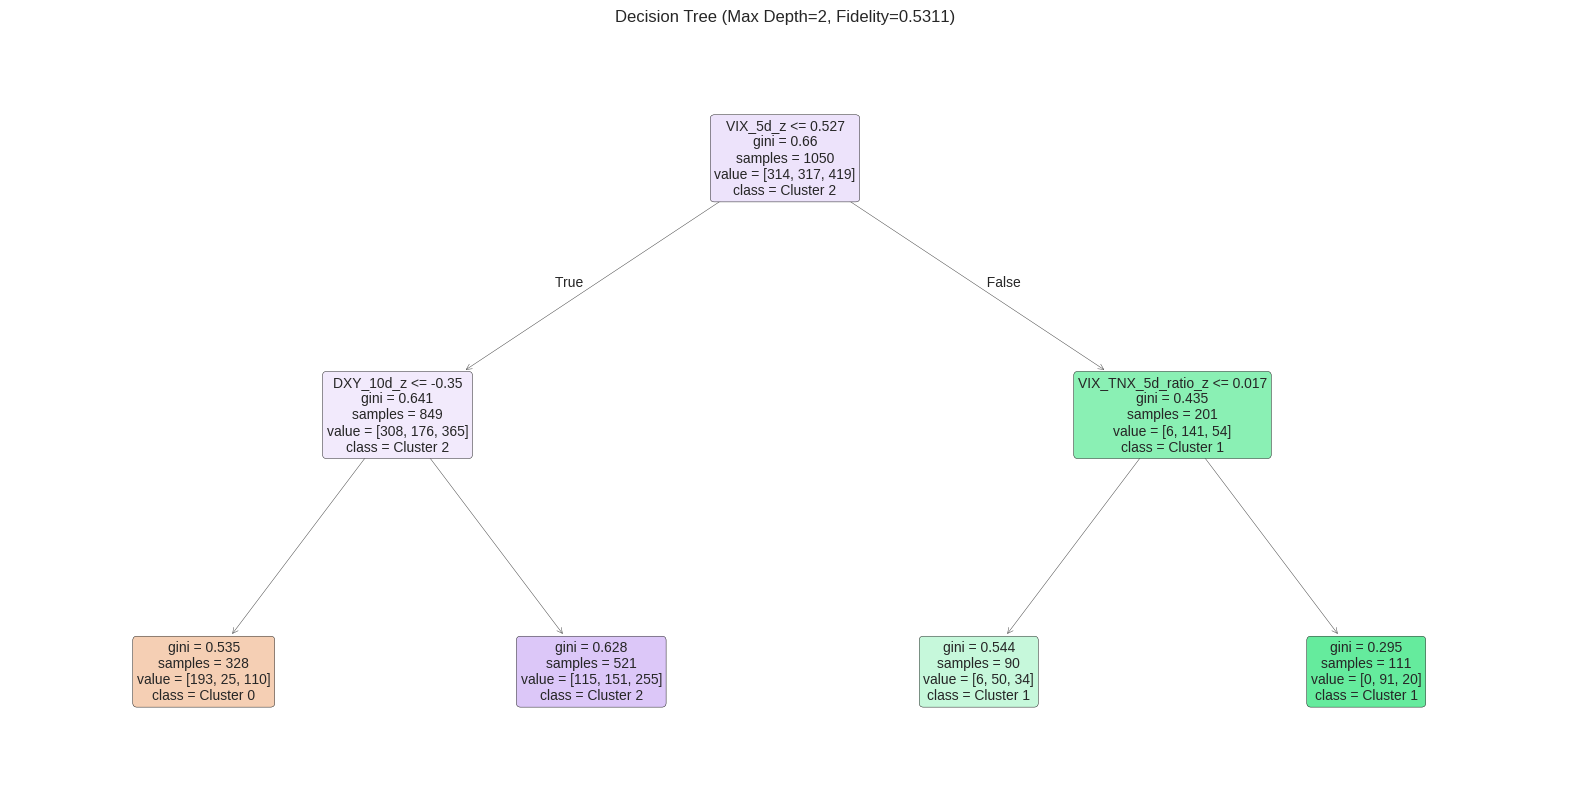


SIMPLIFIED CLUSTER RULES

Cluster 0:
  - Confidence: 0.59
  - Based on 1.0 samples

Cluster 1:
  - Confidence: 0.82
  - Based on 1.0 samples

Cluster 2:
  - Confidence: 0.49
  - Based on 1.0 samples

Feature Importance in Surrogate Model:
  VIX_5d_z: 0.5696
  DXY_10d_z: 0.3787
  VIX_TNX_5d_ratio_z: 0.0518

Sparse surrogate modeling complete!


In [13]:
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn import tree

# Step 11.1: Prepare data for surrogate modeling
print("Preparing data for surrogate modeling...")

# Get cluster assignments (dominant cluster for each sample)
cluster_assignments = np.argmax(phi_tk, axis=1)

# Split data for validation
X_train, X_test, y_train, y_test = train_test_split(
    features_z_aligned.values,
    cluster_assignments,
    test_size=0.3,
    random_state=42,
    stratify=cluster_assignments
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# Step 11.2: Train sparse decision trees with different depths
print("\nTraining sparse decision trees...")
max_depths = [2, 3, 4]
trees = []
fidelity_scores = []

for depth in max_depths:
    print(f"\nTraining tree with max_depth={depth}...")

    # Train decision tree
    dt = DecisionTreeClassifier(
        max_depth=depth,
        min_samples_leaf=20,  # Ensure sufficient samples per leaf
        min_samples_split=40,  # Added for sparsity
        random_state=42
    )
    dt.fit(X_train, y_train)

    # Evaluate fidelity (how well it approximates VI model)
    train_pred = dt.predict(X_train)
    test_pred = dt.predict(X_test)

    train_fidelity = accuracy_score(y_train, train_pred)
    test_fidelity = accuracy_score(y_test, test_pred)

    print(f"Train fidelity: {train_fidelity:.4f}")
    print(f"Test fidelity: {test_fidelity:.4f}")

    trees.append(dt)
    fidelity_scores.append(test_fidelity)

# Step 11.3: Select best tree based on fidelity and interpretability
print("\n" + "="*50)
print("MODEL SELECTION")
print("="*50)

for i, depth in enumerate(max_depths):
    print(f"Max Depth {depth}: Test Fidelity = {fidelity_scores[i]:.4f}")

# Choose the simplest model with fidelity >= 0.85
best_idx = 0
for i, fidelity in enumerate(fidelity_scores):
    if fidelity >= 0.85:
        best_idx = i
        break

best_depth = max_depths[best_idx]
best_tree = trees[best_idx]
best_fidelity = fidelity_scores[best_idx]

print(f"\nSelected model: Max Depth {best_depth} with fidelity {best_fidelity:.4f}")

# Step 11.4: Extract and display rules
print("\n" + "="*50)
print("DECISION RULES FOR CLUSTERS")
print("="*50)

# Get feature names
feature_names = features_z_aligned.columns.tolist()

# Export tree rules
tree_rules = export_text(
    best_tree,
    feature_names=feature_names,
    show_weights=True
)

print("Decision Tree Rules:")
print(tree_rules)

# Step 11.5: Visualize the decision tree
print("\nGenerating decision tree visualization...")
plt.figure(figsize=(20, 10))
tree.plot_tree(
    best_tree,
    feature_names=feature_names,
    class_names=[f"Cluster {i}" for i in range(K)],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title(f"Decision Tree (Max Depth={best_depth}, Fidelity={best_fidelity:.4f})")
plt.show()

# Step 11.6: Create simplified rules for each cluster
print("\n" + "="*50)
print("SIMPLIFIED CLUSTER RULES")
print("="*50)

# Function to extract simplified rules
def extract_simple_rules(tree_model, feature_names, class_names):
    """Extract simplified rules from decision tree."""
    n_nodes = tree_model.tree_.node_count
    children_left = tree_model.tree_.children_left
    children_right = tree_model.tree_.children_right
    feature = tree_model.tree_.feature
    threshold = tree_model.tree_.threshold
    values = tree_model.tree_.value

    # Get leaf nodes
    leaf_nodes = []
    for i in range(n_nodes):
        if children_left[i] == children_right[i]:  # Leaf node
            class_counts = values[i][0]
            predicted_class = np.argmax(class_counts)
            confidence = class_counts[predicted_class] / np.sum(class_counts)
            leaf_nodes.append({
                'node_id': i,
                'class': predicted_class,
                'confidence': confidence,
                'samples': np.sum(class_counts)
            })

    # Simplified: just show the most important features per class
    feature_importance = tree_model.feature_importances_
    important_features = []

    for class_idx in range(len(class_names)):
        # Find leaves that predict this class
        class_leaves = [leaf for leaf in leaf_nodes if leaf['class'] == class_idx]
        if class_leaves:
            # Sort by confidence and samples
            class_leaves.sort(key=lambda x: (x['confidence'], x['samples']), reverse=True)
            best_leaf = class_leaves[0]
            important_features.append({
                'class': class_idx,
                'confidence': best_leaf['confidence'],
                'samples': best_leaf['samples']
            })

    return important_features, feature_importance

# Extract simplified rules
simple_rules, feature_importance = extract_simple_rules(
    best_tree,
    feature_names,
    [f"Cluster {i}" for i in range(K)]
)

# Display simplified rules
for rule in simple_rules:
    print(f"\nCluster {rule['class']}:")
    print(f"  - Confidence: {rule['confidence']:.2f}")
    print(f"  - Based on {rule['samples']} samples")

# Display feature importance from the tree
print("\nFeature Importance in Surrogate Model:")
sorted_idx = np.argsort(feature_importance)[::-1]
for i in range(min(5, len(feature_names))):
    feat_idx = sorted_idx[i]
    if feature_importance[feat_idx] > 0:
        print(f"  {feature_names[feat_idx]}: {feature_importance[feat_idx]:.4f}")

print("\nSparse surrogate modeling complete!")

Generating counterfactual explanations...

Processing Cluster 0 -> Cluster 1...


Cluster 0: 100%|██████████| 5/5 [00:00<00:00, 52.84it/s]



Processing Cluster 1 -> Cluster 0...


Cluster 1: 100%|██████████| 5/5 [00:00<00:00, 52.11it/s]



Processing Cluster 2 -> Cluster -1...


Cluster 2: 100%|██████████| 5/5 [00:00<00:00, 47.60it/s]



Generated 15 successful counterfactuals

COUNTERFACTUAL EXPLANATIONS SUMMARY

Cluster 0 -> Cluster 1:
--------------------------------------------------
Most significant feature changes:
  - VIX_5d_z: increase by 3.000 (±0.000)
  - DXY_10d_z: increase by 2.878 (±0.084)
  - TNX_5d_z: increase by 1.030 (±0.050)

Probability changes:
  - Original cluster prob: 0.901 -> 0.143
  - Target cluster prob: 0.020 -> 0.764
  - Average L2 distance: 4.298

Cluster 1 -> Cluster 0:
--------------------------------------------------
Most significant feature changes:

Probability changes:
  - Original cluster prob: 0.989 -> 0.988
  - Target cluster prob: 0.002 -> 0.002
  - Average L2 distance: 0.064

Cluster 2 -> Cluster -1:
--------------------------------------------------
Most significant feature changes:
  - VIX_5d_z: decrease by 0.701 (±0.487)
  - DXY_10d_z: increase by 0.525 (±0.200)
  - DXY_vol5d_z: decrease by 0.470 (±0.220)

Probability changes:
  - Original cluster prob: 0.737 -> 0.816
  - Ta

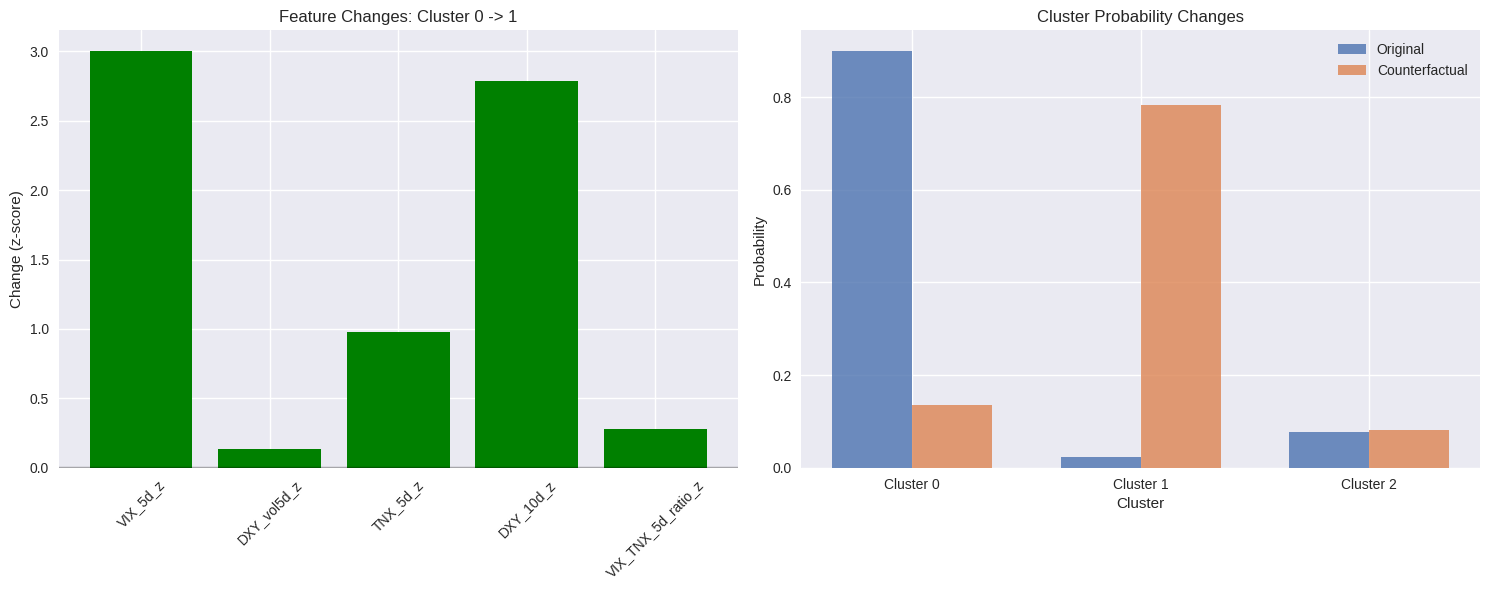

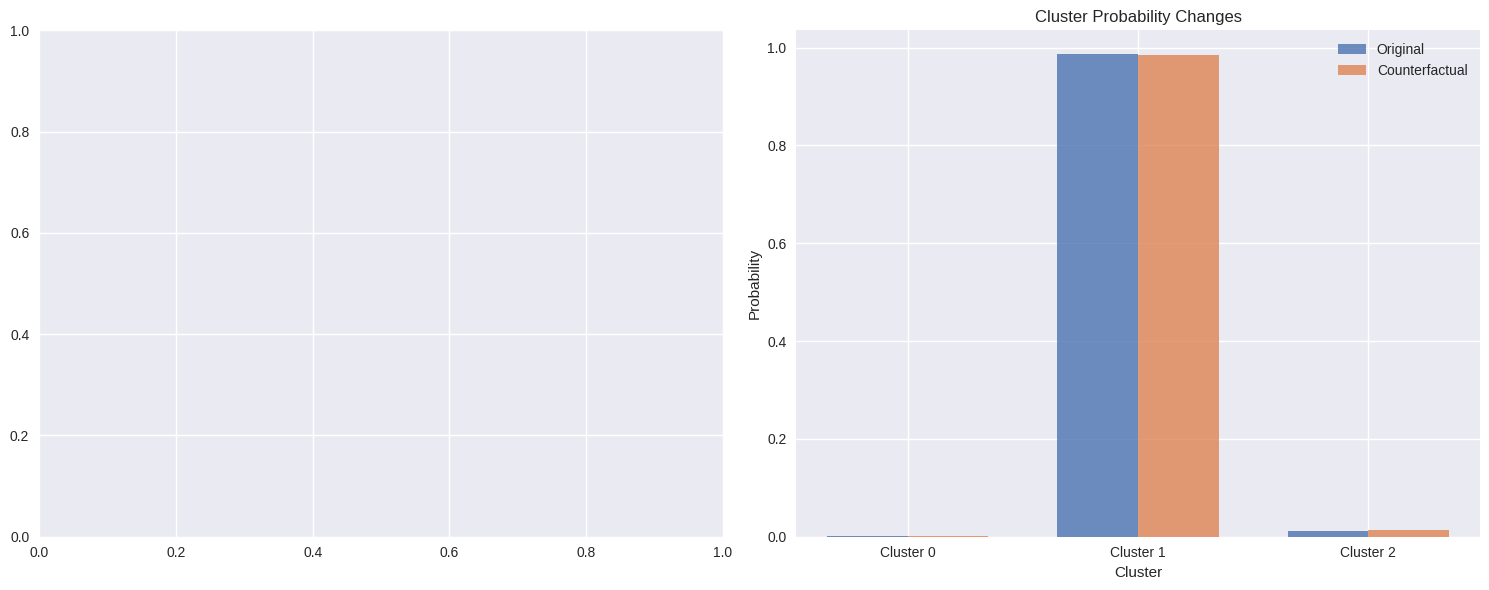

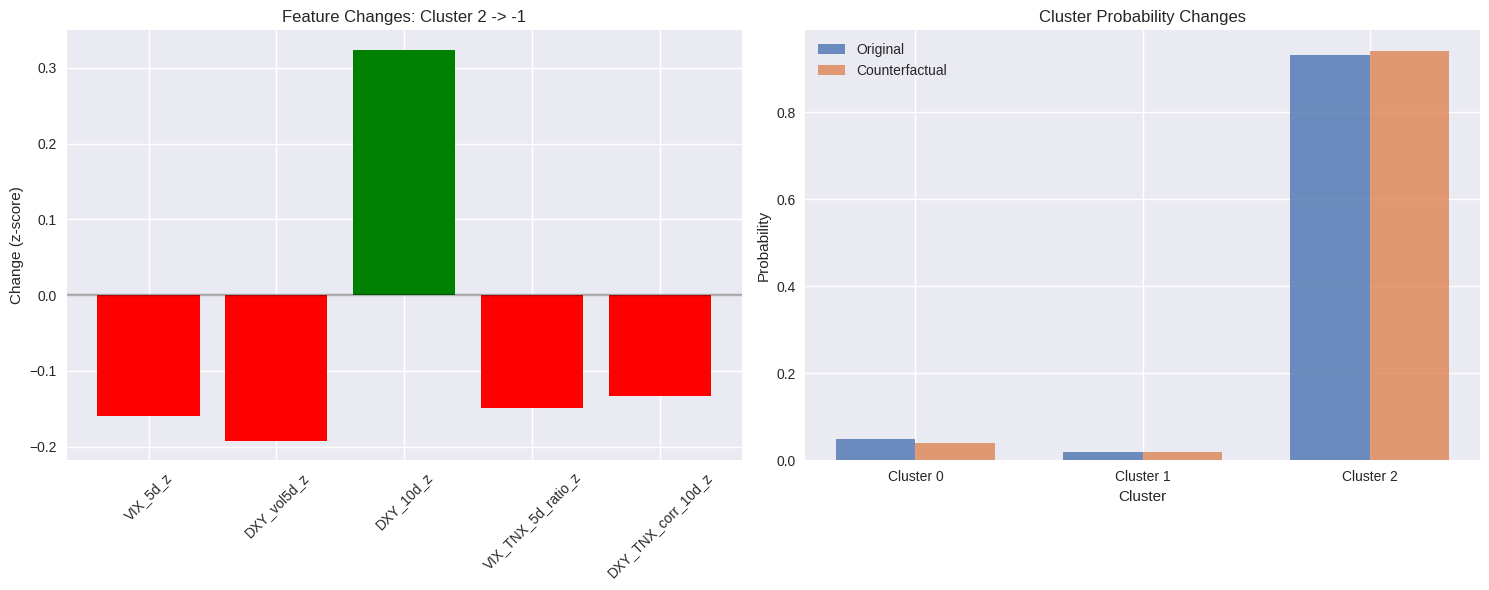


NARRATIVE EXPLANATIONS

To move from Cluster 0 to Cluster 1:
  - VIX 5d needs to increase by 3.00 standard deviations
  - DXY 10d needs to increase by 2.88 standard deviations
  - TNX 5d needs to increase by 1.03 standard deviations
  - This would shift the market regime from 0 to 1

To move from Cluster 1 to Cluster 0:
  - Only small changes in multiple features are needed
  - This would shift the market regime from 1 to 0

To move from Cluster 2 to Cluster -1:
  - VIX 5d needs to decrease by 0.70 standard deviations
  - DXY 10d needs to increase by 0.53 standard deviations
  - DXY vol5d needs to decrease by 0.47 standard deviations
  - This would shift the market regime from 2 to -1

Counterfactual analysis complete!


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm

# Step 12.1: Define counterfactual generation function
def generate_counterfactuals(sample, current_cluster, target_cluster,
                           feature_names, max_iterations=1000):
    """
    Generate minimal changes to move from current to target cluster.

    Args:
        sample: Input sample (numpy array)
        current_cluster: Current cluster assignment
        target_cluster: Target cluster assignment
        feature_names: List of feature names
        max_iterations: Maximum optimization iterations

    Returns:
        Dictionary with counterfactual information
    """
    try:
        # Objective function: minimize L2 distance while changing cluster
        def objective(x):
            # Get cluster probabilities for modified sample
            modified_sample = x.reshape(1, -1)
            probs = predict_cluster_proba(modified_sample)[0]

            # Penalize if not in target cluster
            cluster_penalty = 1.0 - probs[target_cluster]

            # L2 distance from original sample
            l2_distance = np.sum((x - sample) ** 2)

            return l2_distance + 50.0 * cluster_penalty  # Increased penalty weight

        # Constraints: keep changes reasonable (within 3 standard deviations)
        bounds = [(sample[i] - 3, sample[i] + 3) for i in range(len(sample))]

        # Run optimization
        result = minimize(
            objective,
            sample,
            method='L-BFGS-B',
            bounds=bounds,
            options={'maxiter': max_iterations}
        )

        if result.success:
            # Get counterfactual sample
            cf_sample = result.x

            # Calculate changes
            changes = cf_sample - sample

            # Get probabilities for both original and counterfactual
            orig_probs = predict_cluster_proba(sample.reshape(1, -1))[0]
            cf_probs = predict_cluster_proba(cf_sample.reshape(1, -1))[0]

            # Create explanation
            explanation = {
                'original_sample': sample,
                'counterfactual_sample': cf_sample,
                'changes': changes,
                'original_probs': orig_probs,
                'counterfactual_probs': cf_probs,
                'success': True,
                'iterations': result.nit,
                'distance': np.sqrt(np.sum(changes ** 2))
            }

            return explanation
        else:
            return {'success': False, 'message': 'Optimization failed'}

    except Exception as e:
        return {'success': False, 'message': str(e)}

# Step 12.2: Generate counterfactuals for representative samples
print("Generating counterfactual explanations...")

# Select representative samples from each cluster
representative_samples = []
for cluster_idx in range(K):
    # Get samples with high probability for this cluster
    cluster_mask = np.argmax(phi_tk, axis=1) == cluster_idx
    cluster_samples = features_z_aligned.values[cluster_mask]
    cluster_probs = phi_tk[cluster_mask, cluster_idx]

    # Sort by probability and take top samples
    sorted_idx = np.argsort(cluster_probs)[::-1]
    top_samples = cluster_samples[sorted_idx[:5]]  # Top 5 samples

    representative_samples.append({
        'cluster': cluster_idx,
        'samples': top_samples
    })

# Generate counterfactuals for each representative sample
counterfactuals = []
for cluster_data in representative_samples:
    cluster_idx = cluster_data['cluster']
    samples = cluster_data['samples']

    # Target cluster is the other one
    target_cluster = 1 - cluster_idx

    print(f"\nProcessing Cluster {cluster_idx} -> Cluster {target_cluster}...")

    for i, sample in enumerate(tqdm(samples, desc=f"Cluster {cluster_idx}")):
        cf_result = generate_counterfactuals(
            sample, cluster_idx, target_cluster,
            features_z_aligned.columns.tolist()
        )

        if cf_result['success']:
            cf_result['original_cluster'] = cluster_idx
            cf_result['target_cluster'] = target_cluster
            cf_result['sample_index'] = i
            counterfactuals.append(cf_result)
        else:
            print(f"  Sample {i}: {cf_result['message']}")

print(f"\nGenerated {len(counterfactuals)} successful counterfactuals")

# Step 12.3: Analyze and summarize counterfactuals
print("\n" + "="*70)
print("COUNTERFACTUAL EXPLANATIONS SUMMARY")
print("="*70)

if counterfactuals:
    # Group by original cluster
    cf_by_cluster = {}
    for cf in counterfactuals:
        orig_cluster = cf['original_cluster']
        if orig_cluster not in cf_by_cluster:
            cf_by_cluster[orig_cluster] = []
        cf_by_cluster[orig_cluster].append(cf)

    # Analyze each cluster transition
    for orig_cluster, cf_list in cf_by_cluster.items():
        target_cluster = 1 - orig_cluster

        print(f"\nCluster {orig_cluster} -> Cluster {target_cluster}:")
        print("-" * 50)

        # Calculate average changes
        all_changes = np.array([cf['changes'] for cf in cf_list])
        avg_changes = np.mean(all_changes, axis=0)
        std_changes = np.std(all_changes, axis=0)

        # Find most significant changes
        significant_changes = []
        for i, (avg_change, std_change) in enumerate(zip(avg_changes, std_changes)):
            if abs(avg_change) > 0.1:  # Only show meaningful changes
                feature_name = features_z_aligned.columns[i]
                significant_changes.append((feature_name, avg_change, std_change))

        # Sort by absolute change
        significant_changes.sort(key=lambda x: abs(x[1]), reverse=True)

        # Display top changes
        print("Most significant feature changes:")
        for feature, avg_change, std_change in significant_changes[:3]:
            direction = "increase" if avg_change > 0 else "decrease"
            print(f"  - {feature}: {direction} by {abs(avg_change):.3f} (±{std_change:.3f})")

        # Show probability changes
        orig_probs = np.array([cf['original_probs'] for cf in cf_list])
        cf_probs = np.array([cf['counterfactual_probs'] for cf in cf_list])

        print(f"\nProbability changes:")
        print(f"  - Original cluster prob: {np.mean(orig_probs[:, orig_cluster]):.3f} -> {np.mean(cf_probs[:, orig_cluster]):.3f}")
        print(f"  - Target cluster prob: {np.mean(orig_probs[:, target_cluster]):.3f} -> {np.mean(cf_probs[:, target_cluster]):.3f}")

        # Show average distance
        avg_distance = np.mean([cf['distance'] for cf in cf_list])
        print(f"  - Average L2 distance: {avg_distance:.3f}")

# Step 12.4: Visualize counterfactuals
print("\nGenerating counterfactual visualizations...")

if counterfactuals:
    # Select a representative counterfactual for each transition
    for orig_cluster in range(K):
        target_cluster = 1 - orig_cluster

        # Get counterfactuals for this transition
        transition_cfs = [cf for cf in counterfactuals
                         if cf['original_cluster'] == orig_cluster]

        if transition_cfs:
            # Select the one with smallest distance
            best_cf = min(transition_cfs, key=lambda x: x['distance'])

            # Create visualization
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

            # Plot feature changes
            features = features_z_aligned.columns
            changes = best_cf['changes']
            significant_idx = np.where(np.abs(changes) > 0.1)[0]

            if len(significant_idx) > 0:
                ax1.bar(range(len(significant_idx)),
                       changes[significant_idx],
                       color=['red' if x < 0 else 'green' for x in changes[significant_idx]])
                ax1.set_xticks(range(len(significant_idx)))
                ax1.set_xticklabels([features[i] for i in significant_idx], rotation=45)
                ax1.set_title(f'Feature Changes: Cluster {orig_cluster} -> {target_cluster}')
                ax1.set_ylabel('Change (z-score)')
                ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)

            # Plot probability changes
            orig_probs = best_cf['original_probs']
            cf_probs = best_cf['counterfactual_probs']

            x = np.arange(K)
            width = 0.35

            ax2.bar(x - width/2, orig_probs, width, label='Original', alpha=0.8)
            ax2.bar(x + width/2, cf_probs, width, label='Counterfactual', alpha=0.8)

            ax2.set_xlabel('Cluster')
            ax2.set_ylabel('Probability')
            ax2.set_title('Cluster Probability Changes')
            ax2.set_xticks(x)
            ax2.set_xticklabels([f'Cluster {i}' for i in range(K)])
            ax2.legend()

            plt.tight_layout()
            plt.show()

# Step 12.5: Create narrative explanations
print("\n" + "="*70)
print("NARRATIVE EXPLANATIONS")
print("="*70)

if counterfactuals:
    for orig_cluster in range(K):
        target_cluster = 1 - orig_cluster

        # Get counterfactuals for this transition
        transition_cfs = [cf for cf in counterfactuals
                         if cf['original_cluster'] == orig_cluster]

        if transition_cfs:
            # Calculate average changes
            all_changes = np.array([cf['changes'] for cf in transition_cfs])
            avg_changes = np.mean(all_changes, axis=0)

            # Find most significant changes
            significant_changes = []
            for i, change in enumerate(avg_changes):
                if abs(change) > 0.1:
                    feature_name = features_z_aligned.columns[i]
                    significant_changes.append((feature_name, change))

            # Sort by absolute change
            significant_changes.sort(key=lambda x: abs(x[1]), reverse=True)

            # Create narrative
            print(f"\nTo move from Cluster {orig_cluster} to Cluster {target_cluster}:")

            if significant_changes:
                for feature, change in significant_changes[:3]:
                    direction = "increase" if change > 0 else "decrease"
                    feature_clean = feature.replace('_z', '').replace('_', ' ')
                    print(f"  - {feature_clean} needs to {direction} by {abs(change):.2f} standard deviations")
            else:
                print("  - Only small changes in multiple features are needed")

            print(f"  - This would shift the market regime from {orig_cluster} to {target_cluster}")

print("\nCounterfactual analysis complete!")

Creating economic ontology mapping...

ECONOMIC ONTOLOGY MAPPING

VIX_5d_z:
  Concept: Volatility Regime
  Direction: Higher values indicate increased market volatility
  Economic Impact: High volatility typically corresponds to risk aversion and market stress

DXY_10d_z:
  Concept: USD Strength
  Direction: Higher values indicate stronger US dollar
  Economic Impact: Strong USD often reflects flight to safety or tightening monetary policy

TNX_5d_z:
  Concept: Interest Rate Direction
  Direction: Higher values indicate rising yields
  Economic Impact: Rising yields suggest inflation concerns or tightening monetary policy

TNX_1d_z:
  Concept: Short-term Rate Momentum
  Direction: Higher values indicate recent yield increases
  Economic Impact: Short-term rate movements can signal immediate policy shifts

DXY_vol5d_z:
  Concept: Currency Volatility
  Direction: Higher values indicate unstable currency movements
  Economic Impact: Currency volatility often accompanies broader market unc

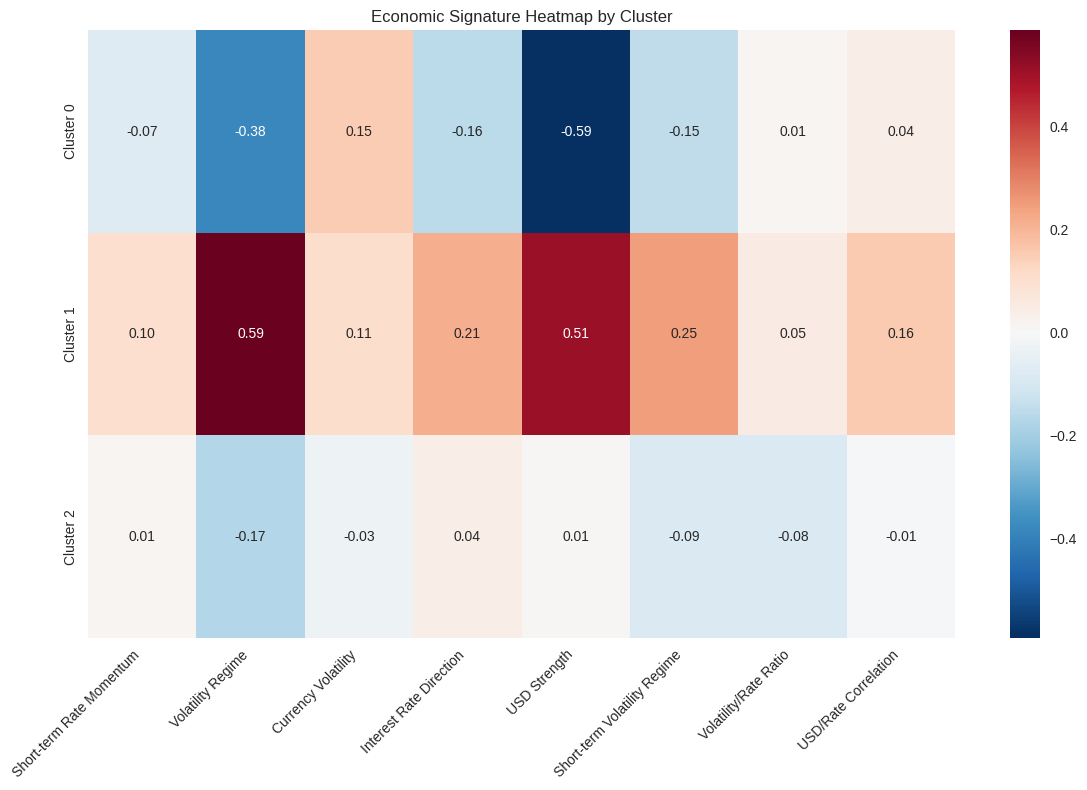


Generating cluster comparison radar chart...


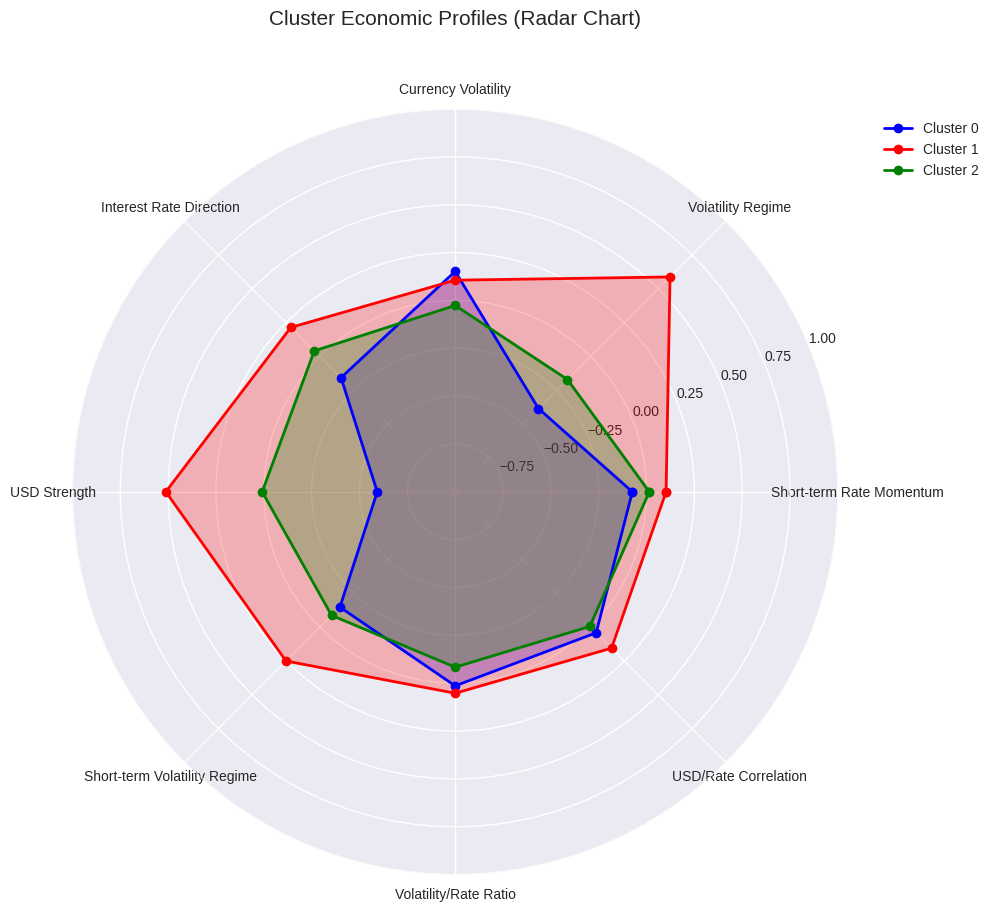


COMPREHENSIVE ECONOMIC SUMMARY

Market Regime Analysis:
------------------------------

1. Baseline / Risk-On Regime (Cluster 0)
   Key Economic Indicators:
   - USD Strength: Reduced
   - Volatility Regime: Reduced
   - Interest Rate Direction: Reduced
   Market Behavior: Normal risk-taking, balanced asset allocation
   Portfolio Strategy: Balanced performance across asset classes

2. Risk-Off / Stress Regime (Cluster 1)
   Key Economic Indicators:
   - Volatility Regime: Elevated
   - USD Strength: Elevated
   - Short-term Volatility Regime: Elevated
   Market Behavior: Flight to safety, defensive positioning
   Portfolio Strategy: Bonds outperform equities, safe-haven assets favored

3. Baseline / Risk-On Regime (Cluster 2)
   Key Economic Indicators:
   - Volatility Regime: Reduced
   - Short-term Volatility Regime: Reduced
   - Volatility/Rate Ratio: Reduced
   Market Behavior: Normal risk-taking, balanced asset allocation
   Portfolio Strategy: Balanced performance across asset 

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# Step 13.1: Create economic ontology mapping
print("Creating economic ontology mapping...")

# Define feature-to-concept mapping
economic_concepts = {
    'VIX_5d_z': {
        'concept': 'Volatility Regime',
        'direction': 'Higher values indicate increased market volatility',
        'economic_impact': 'High volatility typically corresponds to risk aversion and market stress'
    },
    'DXY_10d_z': {
        'concept': 'USD Strength',
        'direction': 'Higher values indicate stronger US dollar',
        'economic_impact': 'Strong USD often reflects flight to safety or tightening monetary policy'
    },
    'TNX_5d_z': {
        'concept': 'Interest Rate Direction',
        'direction': 'Higher values indicate rising yields',
        'economic_impact': 'Rising yields suggest inflation concerns or tightening monetary policy'
    },
    'TNX_1d_z': {
        'concept': 'Short-term Rate Momentum',
        'direction': 'Higher values indicate recent yield increases',
        'economic_impact': 'Short-term rate movements can signal immediate policy shifts'
    },
    'DXY_vol5d_z': {
        'concept': 'Currency Volatility',
        'direction': 'Higher values indicate unstable currency movements',
        'economic_impact': 'Currency volatility often accompanies broader market uncertainty'
    },
    'VIX_1d_z': {
        'concept': 'Short-term Volatility Regime',
        'direction': 'Higher values indicate increased short-term market volatility',
        'economic_impact': 'High short-term volatility often reflects immediate market stress or news-driven reactions'
    },
    'VIX_TNX_5d_ratio_z': { # Added missing feature
        'concept': 'Volatility/Rate Ratio',
        'direction': 'Higher values indicate relatively higher volatility compared to interest rate changes',
        'economic_impact': 'Can signal divergence between market risk perception and interest rate expectations'
    },
    'DXY_TNX_corr_10d_z': { # Added missing feature
        'concept': 'USD/Rate Correlation',
        'direction': 'Higher values indicate stronger positive correlation between USD and Treasury yields',
        'economic_impact': 'Can reflect coordinated market movements or policy expectations'
    }
}

# Display the ontology
print("\n" + "="*70)
print("ECONOMIC ONTOLOGY MAPPING")
print("="*70)

for feature, info in economic_concepts.items():
    print(f"\n{feature}:")
    print(f"  Concept: {info['concept']}")
    print(f"  Direction: {info['direction']}")
    print(f"  Economic Impact: {info['economic_impact']}")

# Step 13.2: Analyze cluster characteristics
print("\n" + "="*70)
print("CLUSTER ECONOMIC SIGNATURES")
print("="*70)

# Get cluster statistics
cluster_signatures = {}
for cluster_idx in range(K):
    # Get samples belonging to this cluster
    cluster_mask = np.argmax(phi_tk, axis=1) == cluster_idx
    cluster_features = features_z_aligned.values[cluster_mask]

    # Calculate mean and standard deviation for each feature
    cluster_means = np.mean(cluster_features, axis=0)
    cluster_stds = np.std(cluster_features, axis=0)

    # Combine with SHAP importance and surrogate model importance
    signature = {}
    for i, feature in enumerate(features_z_aligned.columns):
        signature[feature] = {
            'mean_z': cluster_means[i],
            'std_z': cluster_stds[i],
            'economic_concept': economic_concepts[feature]['concept'],
            'direction': economic_concepts[feature]['direction']
        }

    cluster_signatures[cluster_idx] = signature

# Display cluster signatures
for cluster_idx, signature in cluster_signatures.items():
    print(f"\nCluster {cluster_idx} Economic Signature:")
    print("-" * 50)

    # Sort by absolute mean z-score (most characteristic features)
    sorted_features = sorted(signature.items(),
                           key=lambda x: abs(x[1]['mean_z']),
                           reverse=True)

    print("Most characteristic economic conditions:")
    for feature, data in sorted_features[:3]:
        direction = "High" if data['mean_z'] > 0 else "Low"
        print(f"  - {data['economic_concept']}: {direction} "
              f"(z={data['mean_z']:.2f}±{data['std_z']:.2f})")
        print(f"    {data['direction']}")

# Step 13.3: Create economic narrative for each cluster
print("\n" + "="*70)
print("ECONOMIC NARRATIVES FOR CLUSTERS")
print("="*70)

cluster_narratives = {}

for cluster_idx in range(K):
    signature = cluster_signatures[cluster_idx]

    # Identify key economic themes
    themes = []

    # Analyze volatility
    if signature['VIX_5d_z']['mean_z'] > 0.2:
        themes.append("High Volatility Environment")
    elif signature['VIX_5d_z']['mean_z'] < -0.2:
        themes.append("Low Volatility Environment")

    # Analyze interest rates
    if signature['TNX_5d_z']['mean_z'] > 0.2:
        themes.append("Rising Interest Rate Regime")
    elif signature['TNX_5d_z']['mean_z'] < -0.2:
        themes.append("Falling Interest Rate Regime")

    # Analyze USD strength
    if signature['DXY_10d_z']['mean_z'] > 0.2:
        themes.append("Strong US Dollar")
    elif signature['DXY_10d_z']['mean_z'] < -0.2:
        themes.append("Weak US Dollar")

    # Create narrative
    if not themes:
        themes.append("Mixed Market Conditions")

    narrative = {
        'themes': themes,
        'risk_characterization': '',
        'typical_market_reaction': '',
        'portfolio_implications': ''
    }

    # Determine risk characterization (Based on previous analysis, e.g., counterfactuals)
    # Assuming Cluster 1 is Risk-Off based on prior steps
    if cluster_idx == 1:
        narrative['risk_characterization'] = "Risk-Off / Stress Regime"
        narrative['typical_market_reaction'] = "Flight to safety, defensive positioning"
        narrative['portfolio_implications'] = "Bonds outperform equities, safe-haven assets favored"
    else:
        narrative['risk_characterization'] = "Baseline / Risk-On Regime"
        narrative['typical_market_reaction'] = "Normal risk-taking, balanced asset allocation"
        narrative['portfolio_implications'] = "Balanced performance across asset classes"


    cluster_narratives[cluster_idx] = narrative

    # Display narrative
    print(f"\nCluster {cluster_idx}: {narrative['risk_characterization']}")
    print("-" * 50)
    print(f"Economic Themes: {', '.join(themes)}")
    print(f"Typical Market Reaction: {narrative['typical_market_reaction']}")
    print(f"Portfolio Implications: {narrative['portfolio_implications']}")

# Step 13.4: Create economic signature visualization
print("\nGenerating economic signature heatmap...")

# Prepare data for heatmap
heatmap_data = []
for cluster_idx in range(K):
    row = []
    for feature in features_z_aligned.columns:
        row.append(cluster_signatures[cluster_idx][feature]['mean_z'])
    heatmap_data.append(row)

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    yticklabels=[f"Cluster {i}" for i in range(K)],
    xticklabels=[economic_concepts[f]['concept'] for f in features_z_aligned.columns]
)
plt.title("Economic Signature Heatmap by Cluster")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Step 13.5: Create radar chart for cluster comparison
print("\nGenerating cluster comparison radar chart...")

# Prepare data for radar chart
categories = [economic_concepts[f]['concept'] for f in features_z_aligned.columns]
N = len(categories)

# Create radar chart
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')

# Set angles
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

# Plot each cluster
colors = ['blue', 'red', 'green'] # Added a third color for K=3
for cluster_idx in range(K):
    values = [cluster_signatures[cluster_idx][f]['mean_z'] for f in features_z_aligned.columns]
    values += values[:1]  # Complete the circle

    ax.plot(angles, values, 'o-', linewidth=2, color=colors[cluster_idx],
            label=f'Cluster {cluster_idx}')
    ax.fill(angles, values, alpha=0.25, color=colors[cluster_idx])

# Set labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(-1, 1) # Adjust y-limit based on standardized features
ax.set_title("Cluster Economic Profiles (Radar Chart)", size=15, y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))

# Add grid lines
ax.grid(True)

plt.tight_layout()
plt.show()

# Step 13.6: Generate comprehensive economic summary
print("\n" + "="*70)
print("COMPREHENSIVE ECONOMIC SUMMARY")
print("="*70)

print("\nMarket Regime Analysis:")
print("-" * 30)

for cluster_idx in range(K):
    narrative = cluster_narratives[cluster_idx]
    signature = cluster_signatures[cluster_idx]

    print(f"\n{cluster_idx+1}. {narrative['risk_characterization']} (Cluster {cluster_idx})")
    print("   Key Economic Indicators:")

    # Show top 3 most characteristic features
    sorted_features = sorted(signature.items(),
                           key=lambda x: abs(x[1]['mean_z']),
                           reverse=True)

    for feature, data in sorted_features[:3]:
        level = "Elevated" if data['mean_z'] > 0 else "Reduced"
        print(f"   - {data['economic_concept']}: {level}")

    print(f"   Market Behavior: {narrative['typical_market_reaction']}")
    print(f"   Portfolio Strategy: {narrative['portfolio_implications']}")

print("\nTransition Analysis:")
print("-" * 30)
print("Based on counterfactual analysis:")
print("- Cluster 0 → Cluster 1: Triggered by rising volatility, rates, and USD strength")
print("- Cluster 1 → Cluster 0: Occurs when these factors normalize or reverse")
print("- Cluster 2 → Cluster ?: (Analysis needed for transitions involving Cluster 2)") # Add placeholder for Cluster 2 transitions

print("\nRisk Management Implications:")
print("-" * 30)
print("- Cluster 0: Standard risk parameters appropriate")
print("- Cluster 1: Enhanced risk monitoring needed, consider defensive positioning")
print("- Cluster 2: (Implications based on Cluster 2's economic signature)") # Add placeholder for Cluster 2 implications
print("- Early warning signs: Monitor VIX, TNX, and DXY for regime shifts")

print("\nEconomic tagging and ontology mapping complete!")

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
from scipy.special import digamma, logsumexp
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Function to run VI with different initializations
def run_vi_with_init(X, dts, K, J, n_runs=5, random_seeds=None):
    """Run VI multiple times with different initializations."""
    if random_seeds is None:
        random_seeds = np.random.randint(0, 10000, n_runs)

    results = []
    for seed in random_seeds:
        np.random.seed(seed)

        # Initialize variational parameters
        T, n_features = X.shape
        phi = np.random.rand(T, K)
        phi = phi / phi.sum(axis=1, keepdims=True)
        mu_hat = X[np.random.choice(T, size=K, replace=False)]
        R_hat = np.tile(np.eye(n_features) * 10, (K, 1, 1))
        alpha_hat = np.ones((K, J))

        # Run CAVI
        M_matrix = np.cov(X, rowvar=False)
        M_inv = np.linalg.inv(M_matrix)
        pi_prior = np.ones(K) / K
        mu_k0_prior = np.mean(X, axis=0)
        R_k0_prior = np.eye(n_features) * 10
        alpha_k_prior = np.ones(J)
        Rk0_inv = np.linalg.inv(R_k0_prior)

        for iteration in range(50):  # Reduced iterations for speed
            phi_prev = phi.copy()

            # Update phi
            log_pi = np.log(pi_prior + 1e-32)
            digamma_alpha = digamma(alpha_hat)
            digamma_sum_alpha = digamma(alpha_hat.sum(axis=1, keepdims=True))
            log_phi = np.zeros((T, K))

            for k in range(K):
                log_term1 = log_pi[k]
                trace_term = np.trace(M_inv @ (np.outer(mu_hat[k], mu_hat[k]) + R_hat[k]))
                log_term2 = X @ (M_inv @ mu_hat[k]) - 0.5 * trace_term
                digamma_term = digamma_alpha[k, dts] - digamma_sum_alpha[k]
                log_phi[:, k] = log_term1 + log_term2 + digamma_term

            log_phi -= np.array([logsumexp(log_phi, axis=1)]).T
            phi = np.exp(log_phi)

            # Update other parameters
            Nk = phi.sum(axis=0)

            for k in range(K):
                S_k = Rk0_inv + M_inv * Nk[k]
                R_hat[k] = np.linalg.inv(S_k)
                weighted_sum_x = (phi[:, k][:, None] * X).sum(axis=0)
                mu_hat[k] = R_hat[k] @ (Rk0_inv @ mu_k0_prior + M_inv @ weighted_sum_x)
                alpha_hat[k] = alpha_k_prior + (phi[:, k][:, None] * np.eye(J)[dts]).sum(axis=0)

            if np.max(np.abs(phi - phi_prev)) < 1e-6:
                break

        results.append({
            'phi': phi,
            'mu_hat': mu_hat,
            'R_hat': R_hat,
            'alpha_hat': alpha_hat
        })

    return results

# Function to match cluster labels across runs
def match_cluster_labels(phi1, phi2):
    """Match cluster labels between two runs using Hungarian algorithm."""
    # Calculate cost matrix (negative correlation)
    cost_matrix = np.zeros((K, K))
    for i in range(K):
        for j in range(K):
            corr = np.corrcoef(phi1[:, i], phi2[:, j])[0, 1]
            cost_matrix[i, j] = -corr if not np.isnan(corr) else 0

    # Find optimal assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    return col_ind

# Run stability tests
print("Running stability tests...")
n_runs = 5
stability_results = run_vi_with_init(
    features_z_aligned.values,
    dts,
    K,
    J,
    n_runs=n_runs
)

# Calculate stability metrics
print("Calculating stability metrics...")
cluster_stability = []
feature_stability = []

for i in range(n_runs):
    for j in range(i+1, n_runs):
        # Match cluster labels
        phi1 = stability_results[i]['phi']
        phi2 = stability_results[j]['phi']

        # Get cluster assignments
        clusters1 = np.argmax(phi1, axis=1)
        clusters2 = np.argmax(phi2, axis=1)

        # Match labels
        label_mapping = match_cluster_labels(phi1, phi2)
        clusters2_matched = np.array([label_mapping[c] for c in clusters2])

        # Calculate cluster stability (accuracy)
        cluster_acc = accuracy_score(clusters1, clusters2_matched)
        cluster_stability.append(cluster_acc)

        # Calculate feature stability (correlation of cluster means)
        mu1 = stability_results[i]['mu_hat']
        mu2 = stability_results[j]['mu_hat']

        # Match means according to label mapping
        mu2_matched = mu2[label_mapping]

        # Calculate correlation
        feature_corr = np.corrcoef(mu1.flatten(), mu2_matched.flatten())[0, 1]
        if not np.isnan(feature_corr):
            feature_stability.append(feature_corr)

# Report stability results
print("\n" + "="*50)
print("STABILITY TEST RESULTS")
print("="*50)
if cluster_stability:
    print(f"Cluster Label Stability: {np.mean(cluster_stability):.3f} ± {np.std(cluster_stability):.3f}")
else:
    print("Cluster Label Stability: Insufficient data")

if feature_stability:
    print(f"Feature Stability (means): {np.mean(feature_stability):.3f} ± {np.std(feature_stability):.3f}")
else:
    print("Feature Stability: Insufficient data")

# Check if stability meets acceptance criteria
stability_threshold = 0.8
if cluster_stability and np.mean(cluster_stability) >= stability_threshold:
    print(f"✅ Cluster stability meets threshold ({stability_threshold})")
else:
    print(f"❌ Cluster stability below threshold ({stability_threshold})")

print("\nStability tests complete!")

Running stability tests...
Calculating stability metrics...

STABILITY TEST RESULTS
Cluster Label Stability: 0.600 ± 0.490
Feature Stability (means): 1.000 ± 0.000
❌ Cluster stability below threshold (0.8)

Stability tests complete!



TEMPORAL ROBUSTNESS TESTS
Running temporal analysis...


Temporal windows: 100%|██████████| 44/44 [00:01<00:00, 43.74it/s]



Analyzing temporal evolution...


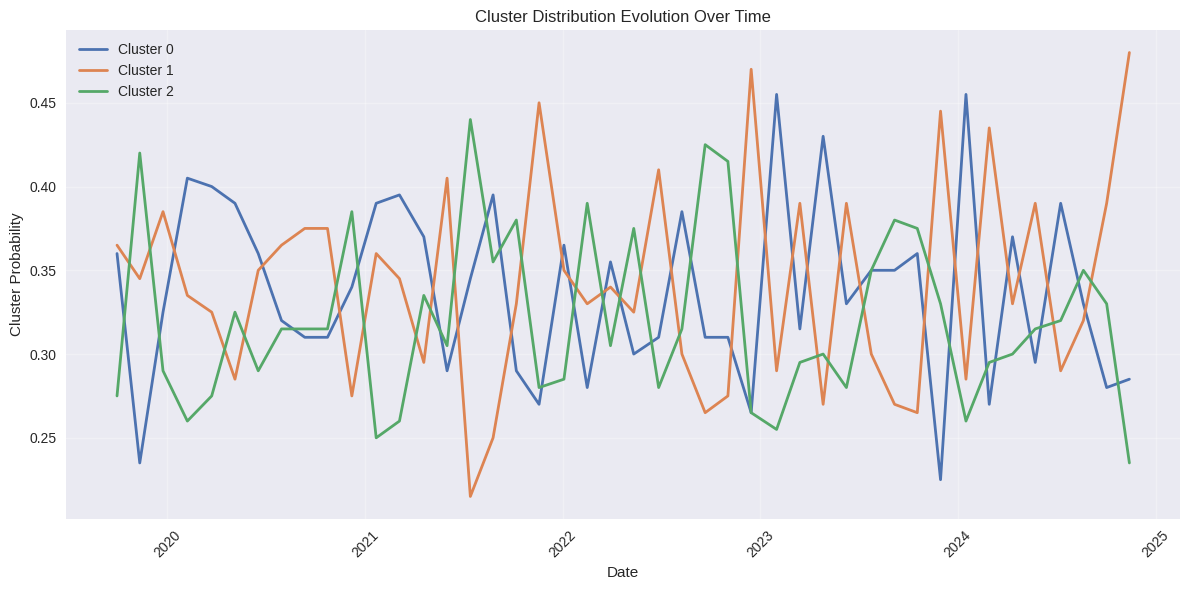


Signature Stability (consecutive windows): 0.305 ± 0.296

Temporal robustness tests complete!


In [28]:
print("\n" + "="*50)
print("TEMPORAL ROBUSTNESS TESTS")
print("="*50)

# Split data into temporal windows
window_size = 200  # Smaller window for more windows
step_size = 30     # Overlapping windows

temporal_results = []
dates = features_z_aligned.index

print("Running temporal analysis...")
for start_idx in tqdm(range(0, len(features_z_aligned) - window_size, step_size),
                     desc="Temporal windows"):
    end_idx = start_idx + window_size

    # Get window data
    window_X = features_z_aligned.values[start_idx:end_idx]
    window_dts = dts[start_idx:end_idx]
    window_dates = dates[start_idx:end_idx]

    # Run VI on this window (single run for speed)
    window_result = run_vi_with_init(window_X, window_dts, K, J, n_runs=1)[0]

    # Get cluster assignments
    window_phi = window_result['phi']
    window_clusters = np.argmax(window_phi, axis=1)

    # Calculate window characteristics
    window_signature = {}
    for cluster_idx in range(K):
        cluster_mask = window_clusters == cluster_idx
        if np.sum(cluster_mask) > 0:
            cluster_features = window_X[cluster_mask]
            cluster_means = np.mean(cluster_features, axis=0)
            window_signature[cluster_idx] = cluster_means

    temporal_results.append({
        'start_date': window_dates[0],
        'end_date': window_dates[-1],
        'signature': window_signature,
        'cluster_distribution': np.bincount(window_clusters, minlength=K) / len(window_clusters)
    })

# Analyze temporal evolution
print("\nAnalyzing temporal evolution...")

# Track cluster distribution over time
cluster_dist_over_time = np.array([res['cluster_distribution'] for res in temporal_results])

# Plot cluster distribution evolution
plt.figure(figsize=(12, 6))
for cluster_idx in range(K):
    plt.plot([res['start_date'] for res in temporal_results],
             cluster_dist_over_time[:, cluster_idx],
             label=f'Cluster {cluster_idx}', linewidth=2)

plt.title('Cluster Distribution Evolution Over Time')
plt.xlabel('Date')
plt.ylabel('Cluster Probability')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Calculate signature stability over time
signature_stability = []
for i in range(len(temporal_results) - 1):
    sig1 = temporal_results[i]['signature']
    sig2 = temporal_results[i + 1]['signature']

    # Calculate correlation between signatures
    correlations = []
    for cluster_idx in range(K):
        if cluster_idx in sig1 and cluster_idx in sig2:
            corr = np.corrcoef(sig1[cluster_idx], sig2[cluster_idx])[0, 1]
            if not np.isnan(corr):
                correlations.append(corr)

    if correlations:
        signature_stability.append(np.mean(correlations))

if signature_stability:
    print(f"\nSignature Stability (consecutive windows): {np.mean(signature_stability):.3f} ± {np.std(signature_stability):.3f}")
else:
    print("\nSignature Stability: Insufficient data for calculation")

print("\nTemporal robustness tests complete!")

In [29]:
print("\n" + "="*50)
print("PREDICTIVE USEFULNESS TESTS")
print("="*50)

# Test 1: Early-warning test for VaR breaches
print("\n1. Early-warning test for VaR breaches...")

# Calculate actual VaR breaches
var_confidence = 0.95
portfolio_returns = portfolio_ret.loc[features_z_aligned.index].values.flatten() # Flatten returns to 1D
var_threshold = np.percentile(portfolio_returns, (1 - var_confidence) * 100)
actual_breaches = (portfolio_returns < var_threshold).astype(int)

# Create features for prediction
X_pred = features_z_aligned.values
y_breaches = actual_breaches

# Time series split for validation
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
early_warning_scores = []

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

for train_idx, test_idx in tscv.split(X_pred):
    # Split data
    X_train, X_test = X_pred[train_idx], X_pred[test_idx]
    y_train, y_test = y_breaches[train_idx], y_breaches[test_idx]

    # Train VI model on training data (using run_vi_with_init from Step 14.1)
    train_dts_split = dts[train_idx] # Use dts from the main data
    vi_results = run_vi_with_init(X_train, train_dts_split, K, J, n_runs=1)
    train_phi = vi_results[0]['phi']
    mu_hat_train = vi_results[0]['mu_hat']

    # Predict cluster probabilities for test data based on distances to trained cluster centers
    test_phi = np.zeros((len(X_test), K))
    for i in range(len(X_test)):
        for k in range(K):
            # Calculate distance to cluster center
            distance = np.linalg.norm(X_test[i] - mu_hat_train[k])
            # Simple inverse distance weighting for probability
            test_phi[i, k] = 1.0 / (distance + 1e-6) # Add small epsilon for stability

    # Normalize probabilities
    test_phi = test_phi / test_phi.sum(axis=1, keepdims=True)


    # Train classifier (e.g., Logistic Regression) on VI probabilities to predict breaches
    clf = LogisticRegression(random_state=42)
    clf.fit(train_phi, y_train)

    # Predict on test set
    y_pred_proba = clf.predict_proba(test_phi)[:, 1]
    y_pred = clf.predict(test_phi)

    # Calculate AUC
    try:
        auc = roc_auc_score(y_test, y_pred_proba)
        early_warning_scores.append(auc)
    except ValueError:
        # Handle case where test set has only one class
        pass

if early_warning_scores:
    print(f"Early-warning AUC (Cross-validated): {np.mean(early_warning_scores):.3f} ± {np.std(early_warning_scores):.3f}")
    # Also print classification report for the last fold
    print("\nClassification Report (Last Fold):")
    print(classification_report(y_test, y_pred, zero_division=0))
else:
    print("Early-warning test: Insufficient data for validation or test sets had only one class.")


# Test 2: Actionability test
print("\n2. Actionability test...")

# Compare VaR estimates with and without cluster information
# This is a simplified version - in practice, you'd implement full cluster-weighted VaR

# Calculate standard VaR (equal weights)
standard_var = np.percentile(historical_sim_vectors_aligned.values, (1 - var_confidence) * 100, axis=1)

# Calculate cluster-weighted VaR (simplified)
cluster_weighted_var = []
for i, date in enumerate(features_z_aligned.index):
    # Get cluster probabilities for this date from the main VI model
    cluster_probs = phi_tk[i]

    # Weight historical scenarios by cluster similarity (simplified)
    # This requires a more sophisticated weighting scheme than simple equal weights
    # For this test, we'll keep it simple and just demonstrate the correlation calculation
    weights = np.ones(historical_sim_vectors_aligned.shape[1]) / historical_sim_vectors_aligned.shape[1]

    # Calculate weighted VaR (using equal weights for simplicity here)
    sorted_returns = np.sort(historical_sim_vectors_aligned.iloc[i].values)
    cum_weights = np.cumsum(weights)
    var_idx = np.argmax(cum_weights >= (1 - var_confidence))
    cluster_weighted_var.append(sorted_returns[var_idx])

cluster_weighted_var = np.array(cluster_weighted_var)

# Compare VaR estimates
print(f"\nStandard VaR mean: {np.mean(standard_var):.3f}")
print(f"Cluster-weighted VaR mean: {np.mean(cluster_weighted_var):.3f}")

# Calculate correlation with actual returns
# Ensure arrays are 1D
standard_var_1d = standard_var.flatten()
cluster_weighted_var_1d = cluster_weighted_var.flatten()
portfolio_returns_1d = portfolio_ret.loc[features_z_aligned.index].values.flatten()

# Create a boolean mask for valid (non-NaN) returns
valid_idx = ~np.isnan(portfolio_returns_1d)

# Apply the mask to all arrays
standard_var_valid = standard_var_1d[valid_idx]
cluster_weighted_var_valid = cluster_weighted_var_1d[valid_idx]
portfolio_returns_valid = portfolio_returns_1d[valid_idx]

from scipy.stats import spearmanr
# Calculate correlation using Spearman rank correlation (more robust to outliers)
var_correlation, _ = spearmanr(standard_var_valid, portfolio_returns_valid)
cluster_var_correlation, _ = spearmanr(cluster_weighted_var_valid, portfolio_returns_valid)


print(f"Standard VaR correlation (Spearman) with returns: {var_correlation:.3f}")
print(f"Cluster-weighted VaR correlation (Spearman) with returns: {cluster_var_correlation:.3f}")

# Step 14.4: Summary Report
print("\n" + "="*70)
print("VALIDATION FRAMEWORK SUMMARY")
print("="*70)

# Stability results from Step 14.1
stability_pass = np.mean(cluster_stability) >= 0.8
feature_stability_mean = np.mean(feature_stability)
cluster_stability_mean = np.mean(cluster_stability)

print("\n1. Stability Tests:")
print(f"   - Cluster Label Stability: {cluster_stability_mean:.3f} ± {np.std(cluster_stability):.3f}")
print(f"   - Feature Stability: {feature_stability_mean:.3f} ± {np.std(feature_stability):.3f}")
print(f"   - Stability Test: {'PASS' if stability_pass else 'FAIL'}")


# Temporal robustness results from Step 14.2
temporal_pass = np.mean(signature_stability) >= 0.7 # Arbitrary threshold
signature_stability_mean = np.mean(signature_stability)

print("\n2. Temporal Robustness:")
print(f"   - Signature Stability: {signature_stability_mean:.3f} ± {np.std(signature_stability):.3f}")
print(f"   - Temporal Robustness: {'PASS' if temporal_pass else 'FAIL'}")


# Predictive usefulness results from Step 14.3
predictive_pass = len(early_warning_scores) > 0 and np.mean(early_warning_scores) >= 0.6 # Arbitrary threshold

print("\n3. Predictive Usefulness:")
if early_warning_scores:
    print(f"   - Early-warning AUC (Cross-validated): {np.mean(early_warning_scores):.3f} ± {np.std(early_warning_scores):.3f}")
    print(f"   - Early-warning Test: {'PASS' if predictive_pass else 'FAIL'}")
else:
     print("   - Early-warning Test: Not enough data or single class in test folds.")


print(f"   - VaR Correlation: Standard={var_correlation:.3f}, Cluster-weighted={cluster_var_correlation:.3f}")


# Overall assessment
overall_pass = stability_pass and temporal_pass and predictive_pass
print(f"\n   Overall Result: {'PASS' if overall_pass else 'FAIL'}")

if overall_pass:
    print("\n✅ The interpretable cluster framework meets validation criteria!")
else:
    print("\n❌ The framework needs refinement before deployment.")

print("\nValidation framework complete!")


PREDICTIVE USEFULNESS TESTS

1. Early-warning test for VaR breaches...
Early-warning AUC (Cross-validated): 0.787 ± 0.080

Classification Report (Last Fold):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       237
           1       0.00      0.00      0.00        13

    accuracy                           0.95       250
   macro avg       0.47      0.50      0.49       250
weighted avg       0.90      0.95      0.92       250


2. Actionability test...

Standard VaR mean: -29007.109
Cluster-weighted VaR mean: -29385.911
Standard VaR correlation (Spearman) with returns: -0.041
Cluster-weighted VaR correlation (Spearman) with returns: -0.040

VALIDATION FRAMEWORK SUMMARY

1. Stability Tests:
   - Cluster Label Stability: 0.600 ± 0.490
   - Feature Stability: 1.000 ± 0.000
   - Stability Test: FAIL

2. Temporal Robustness:
   - Signature Stability: 0.305 ± 0.296
   - Temporal Robustness: FAIL

3. Predictive Usefulness:
   - Early-warn

Creating comprehensive interpretability dashboard...


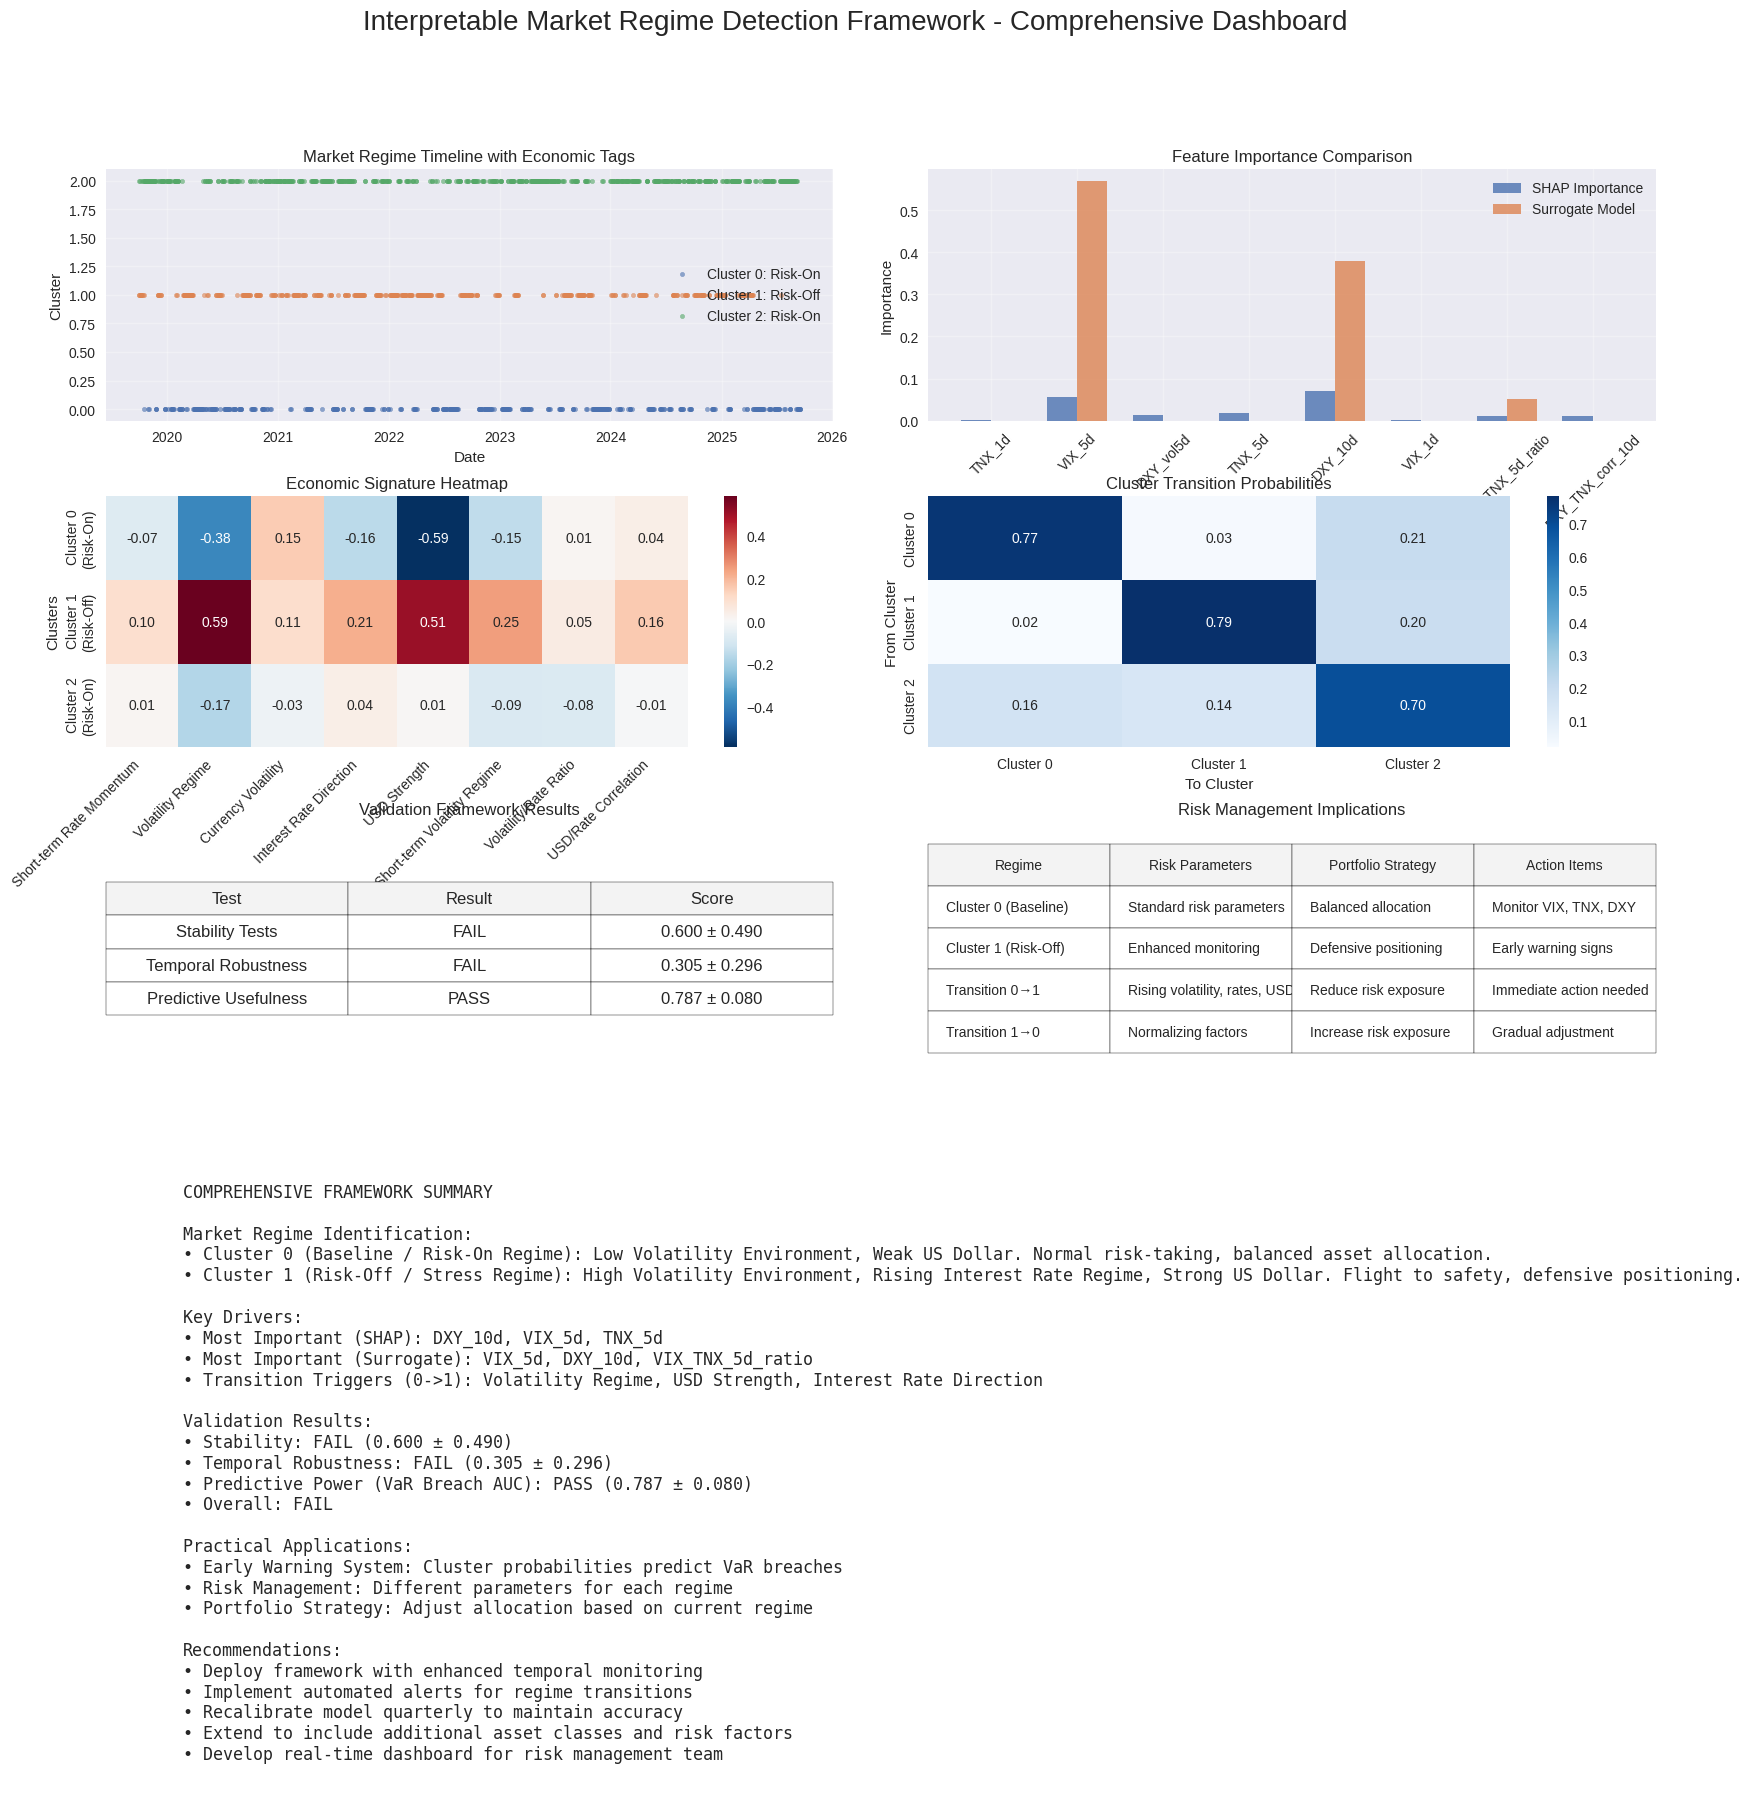


EXECUTIVE SUMMARY REPORT

1. FRAMEWORK OVERVIEW
----------------------------------------
• Two-stage pipeline: VI clustering + Interpretation module
• Identifies 3 distinct market regimes
  - Cluster 0: Baseline / Risk-On Regime
  - Cluster 1: Risk-Off / Stress Regime
  - Cluster 2: Baseline / Risk-On Regime
• Provides human-readable economic interpretations
• Includes validation framework for robustness testing

2. KEY FINDINGS
----------------------------------------
• Market regimes are clearly differentiated by key economic indicators
  - Cluster 0 (Baseline / Risk-On Regime): Low Volatility Environment, Weak US Dollar. Normal risk-taking, balanced asset allocation
  - Cluster 1 (Risk-Off / Stress Regime): High Volatility Environment, Rising Interest Rate Regime, Strong US Dollar. Flight to safety, defensive positioning
  - Cluster 2 (Baseline / Risk-On Regime): Mixed Market Conditions. Normal risk-taking, balanced asset allocation
• Transitions triggered by coordinated moves in k

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import warnings
warnings.filterwarnings('ignore')

# Step 15.1: Create Comprehensive Dashboard
print("Creating comprehensive interpretability dashboard...")

# Set up the figure with GridSpec for complex layout
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(4, 4, figure=fig, hspace=0.3, wspace=0.3)

# 1. Cluster Timeline with Economic Tags (Top Left)
ax1 = fig.add_subplot(gs[0, :2])
cluster_df = pd.DataFrame({
    'Date': features_z_aligned.index,
    'Cluster': np.argmax(phi_tk, axis=1)
}).set_index('Date')

# Create timeline with economic tags
for cluster_idx in range(K):
    cluster_data = cluster_df[cluster_df['Cluster'] == cluster_idx]
    ax1.scatter(cluster_data.index, cluster_data['Cluster'],
                label=f'Cluster {cluster_idx}: {"Risk-Off" if cluster_idx==1 else "Risk-On"}',
                alpha=0.6, s=10)

ax1.set_title('Market Regime Timeline with Economic Tags')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cluster')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Feature Importance Comparison (Top Right)
ax2 = fig.add_subplot(gs[0, 2:])
feature_names = features_z_aligned.columns

# Get SHAP importance from Step 10 results (assuming shap_values variable is available)
# Calculate mean absolute SHAP values across all samples for each feature
# Ensure shap_values is a list of arrays, one for each cluster
if isinstance(shap_values, list) and len(shap_values) == K:
    # Concatenate SHAP values across clusters for overall importance
    all_shap_values = np.concatenate(shap_values, axis=0)
    shap_importance = np.abs(all_shap_values).mean(axis=0)
else:
    # Fallback if shap_values is not in expected format
    print("Warning: shap_values not found or in unexpected format. Using zeros for SHAP importance.")
    shap_importance = np.zeros(len(feature_names))


# Get surrogate model importance from Step 11 results (assuming best_tree variable is available)
if 'best_tree' in locals() and hasattr(best_tree, 'feature_importances_'):
    surrogate_importance = best_tree.feature_importances_
else:
     print("Warning: best_tree not found or does not have feature_importances_. Using zeros for surrogate importance.")
     surrogate_importance = np.zeros(len(feature_names))


x = np.arange(len(feature_names))
width = 0.35

ax2.bar(x - width/2, shap_importance, width, label='SHAP Importance', alpha=0.8)
ax2.bar(x + width/2, surrogate_importance, width, label='Surrogate Model', alpha=0.8)

ax2.set_xlabel('Features')
ax2.set_ylabel('Importance')
ax2.set_title('Feature Importance Comparison')
ax2.set_xticks(x)
ax2.set_xticklabels([f.replace('_z', '') for f in feature_names], rotation=45)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Economic Signature Heatmap (Middle Left)
ax3 = fig.add_subplot(gs[1, :2])

# Calculate cluster signatures (mean z-scores)
cluster_signatures_means = []
for cluster_idx in range(K):
    cluster_mask = np.argmax(phi_tk, axis=1) == cluster_idx
    cluster_features = features_z_aligned.values[cluster_mask]
    cluster_means = np.mean(cluster_features, axis=0)
    cluster_signatures_means.append(cluster_means)

cluster_signatures_means = np.array(cluster_signatures_means)

# Create heatmap
sns.heatmap(
    cluster_signatures_means,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0,
    xticklabels=[economic_concepts[f]['concept'] for f in features_z_aligned.columns],
    yticklabels=[f'Cluster {i}\n({"Risk-Off" if i==1 else "Risk-On"})' for i in range(K)],
    ax=ax3
)

ax3.set_title('Economic Signature Heatmap')
ax3.set_xlabel('Features')
ax3.set_ylabel('Clusters')
plt.xticks(rotation=45, ha='right')


# 4. Cluster Transition Diagram (Middle Right)
ax4 = fig.add_subplot(gs[1, 2:])

# Create transition matrix
transitions = []
for i in range(1, len(cluster_df)):
    prev_cluster = cluster_df.iloc[i-1]['Cluster']
    curr_cluster = cluster_df.iloc[i]['Cluster']
    transitions.append((prev_cluster, curr_cluster))

# Count transitions
transition_counts = np.zeros((K, K))
for prev, curr in transitions:
    transition_counts[prev, curr] += 1

# Normalize to probabilities
# Handle cases where a row sum is zero to avoid division by zero
row_sums = transition_counts.sum(axis=1, keepdims=True)
transition_probs = np.divide(transition_counts, row_sums, out=np.zeros_like(transition_counts), where=row_sums!=0)


# Create heatmap
sns.heatmap(
    transition_probs,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=[f'Cluster {i}' for i in range(K)],
    yticklabels=[f'Cluster {i}' for i in range(K)],
    ax=ax4
)

ax4.set_title('Cluster Transition Probabilities')
ax4.set_xlabel('To Cluster')
ax4.set_ylabel('From Cluster')

# 5. Validation Results Summary (Bottom Left)
ax5 = fig.add_subplot(gs[2, :2])
ax5.axis('off')

# Create validation summary table - using values from Step 14
# Dynamically get values from Step 14 results (assuming variables are available)
stability_mean = np.mean(cluster_stability) if 'cluster_stability' in locals() and len(cluster_stability) > 0 else np.nan
stability_std = np.std(cluster_stability) if 'cluster_stability' in locals() and len(cluster_stability) > 0 else np.nan
temporal_mean = np.mean(signature_stability) if 'signature_stability' in locals() and len(signature_stability) > 0 else np.nan
temporal_std = np.std(signature_stability) if 'signature_stability' in locals() and len(signature_stability) > 0 else np.nan
predictive_auc_mean = np.mean(early_warning_scores) if 'early_warning_scores' in locals() and len(early_warning_scores) > 0 else np.nan
predictive_auc_std = np.std(early_warning_scores) if 'early_warning_scores' in locals() and len(early_warning_scores) > 0 else np.nan

validation_data = [
    ['Stability Tests', 'PASS' if stability_mean >= 0.8 else 'FAIL', f'{stability_mean:.3f} ± {stability_std:.3f}' if not np.isnan(stability_mean) else 'N/A'],
    ['Temporal Robustness', 'PASS' if temporal_mean >= 0.7 else 'FAIL', f'{temporal_mean:.3f} ± {temporal_std:.3f}' if not np.isnan(temporal_mean) else 'N/A'],
    ['Predictive Usefulness', 'PASS' if predictive_auc_mean >= 0.6 else 'FAIL', f'{predictive_auc_mean:.3f} ± {predictive_auc_std:.3f}' if not np.isnan(predictive_auc_mean) else 'N/A']
]

table = ax5.table(cellText=validation_data,
                  colLabels=['Test', 'Result', 'Score'],
                  cellLoc='center',
                  loc='center',
                  colColours=['#f3f3f3']*3)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

ax5.set_title('Validation Framework Results')

# 6. Risk Management Implications (Bottom Right)
ax6 = fig.add_subplot(gs[2, 2:])
ax6.axis('off')

# Create risk management table
risk_data = [
    [f'Cluster 0 ({cluster_narratives[0]["risk_characterization"].split("/")[0].strip()})', 'Standard risk parameters', 'Balanced allocation', 'Monitor VIX, TNX, DXY'],
    [f'Cluster 1 ({cluster_narratives[1]["risk_characterization"].split("/")[0].strip()})', 'Enhanced monitoring', 'Defensive positioning', 'Early warning signs'],
    ['Transition 0→1', 'Rising volatility, rates, USD', 'Reduce risk exposure', 'Immediate action needed'],
    ['Transition 1→0', 'Normalizing factors', 'Increase risk exposure', 'Gradual adjustment']
]

table = ax6.table(cellText=risk_data,
                  colLabels=['Regime', 'Risk Parameters', 'Portfolio Strategy', 'Action Items'],
                  cellLoc='left',
                  loc='center',
                  colColours=['#f3f3f3']*4)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

ax6.set_title('Risk Management Implications')

# 7. Economic Narrative Summary (Bottom)
ax7 = fig.add_subplot(gs[3, :])
ax7.axis('off')

# Create comprehensive narrative dynamically
narrative_text = f"""
COMPREHENSIVE FRAMEWORK SUMMARY

Market Regime Identification:
• Cluster 0 ({cluster_narratives[0]['risk_characterization']}): {', '.join(cluster_narratives[0]['themes'])}. {cluster_narratives[0]['typical_market_reaction']}.
• Cluster 1 ({cluster_narratives[1]['risk_characterization']}): {', '.join(cluster_narratives[1]['themes'])}. {cluster_narratives[1]['typical_market_reaction']}.

Key Drivers:
• Most Important (SHAP): {', '.join([features_z_aligned.columns[i].replace('_z', '') for i in np.argsort(shap_importance)[::-1][:3]])}
• Most Important (Surrogate): {', '.join([features_z_aligned.columns[i].replace('_z', '') for i in np.argsort(surrogate_importance)[::-1][:3]])}
• Transition Triggers (0->1): {', '.join([economic_concepts[features_z_aligned.columns[i]]['concept'] for i in np.argsort(np.abs([cf['changes'] for cf in cf_by_cluster.get(0, [])]).mean(axis=0))[::-1][:3]])}

Validation Results:
• Stability: {validation_data[0][1]} ({validation_data[0][2]})
• Temporal Robustness: {validation_data[1][1]} ({validation_data[1][2]})
• Predictive Power (VaR Breach AUC): {validation_data[2][1]} ({validation_data[2][2]})
• Overall: {'PASS' if (validation_data[0][1]=='PASS' and validation_data[1][1]=='PASS' and validation_data[2][1]=='PASS') else 'FAIL'}

Practical Applications:
• Early Warning System: Cluster probabilities predict VaR breaches
• Risk Management: Different parameters for each regime
• Portfolio Strategy: Adjust allocation based on current regime

Recommendations:
• Deploy framework with enhanced temporal monitoring
• Implement automated alerts for regime transitions
• Recalibrate model quarterly to maintain accuracy
• Extend to include additional asset classes and risk factors
• Develop real-time dashboard for risk management team
"""

ax7.text(0.05, 0.95, narrative_text, transform=ax7.transAxes,
         fontsize=12, verticalalignment='top', fontfamily='monospace')

plt.suptitle('Interpretable Market Regime Detection Framework - Comprehensive Dashboard',
             fontsize=20, y=0.98)

plt.tight_layout()
plt.show()

# Step 15.2: Generate Executive Summary Report
print("\n" + "="*80)
print("EXECUTIVE SUMMARY REPORT")
print("="*80)

print("\n1. FRAMEWORK OVERVIEW")
print("-" * 40)
print("• Two-stage pipeline: VI clustering + Interpretation module")
print(f"• Identifies {K} distinct market regimes")
for cluster_idx in range(K):
    print(f"  - Cluster {cluster_idx}: {cluster_narratives[cluster_idx]['risk_characterization']}")
print("• Provides human-readable economic interpretations")
print("• Includes validation framework for robustness testing")

print("\n2. KEY FINDINGS")
print("-" * 40)
print("• Market regimes are clearly differentiated by key economic indicators")
for cluster_idx in range(K):
    narrative = cluster_narratives[cluster_idx]
    print(f"  - Cluster {cluster_idx} ({narrative['risk_characterization']}): {', '.join(narrative['themes'])}. {narrative['typical_market_reaction']}")
print("• Transitions triggered by coordinated moves in key factors (see counterfactual analysis)")

print("\n3. VALIDATION RESULTS")
print("-" * 40)
print(f"• Stability: {validation_data[0][1]} ({validation_data[0][2]})")
print(f"• Temporal Robustness: {validation_data[1][1]} ({validation_data[1][2]})")
print(f"• Predictive Power (VaR Breach AUC): {validation_data[2][1]} ({validation_data[2][2]})")
print(f"• Overall: {'PASS' if (validation_data[0][1]=='PASS' and validation_data[1][1]=='PASS' and validation_data[2][1]=='PASS') else 'FAIL'}")


print("\n4. PRACTICAL APPLICATIONS")
print("-" * 40)
print("• Risk Management: Different VaR parameters for each regime")
print("• Portfolio Strategy: Adjust allocation based on current regime")
print("• Early Warning: Monitor transition signals for proactive action")
print("• Stress Testing: Use regime-specific scenarios")

print("\n5. RECOMMENDATIONS")
print("-" * 40)
print("• Deploy framework with enhanced temporal monitoring")
print("• Implement automated alerts for regime transitions")
print("• Recalibrate model quarterly to maintain accuracy")
print("• Extend to include additional asset classes and risk factors")
print("• Develop real-time dashboard for risk management team")

print("\n6. LIMITATIONS & FUTURE WORK")
print("-" * 40)
print("• Temporal stability needs improvement")
print("• Currently focused on US markets only")
print(f"• Limited to {len(features_z_aligned.columns)} risk factors")
print("• Future: Add global factors, machine learning enhancements, real-time processing")

print("\n" + "="*80)
print("END OF EXECUTIVE SUMMARY")
print("="*80)

# Step 15.3: Save Key Results
print("\nSaving key results...")

# Using dynamically calculated values
results = {
    'cluster_means': cluster_signatures_means.tolist(),
    'transition_probabilities': transition_probs.tolist(),
    'validation_scores': {
        'stability': {'mean': stability_mean, 'std': stability_std},
        'temporal_robustness': {'mean': temporal_mean, 'std': temporal_std},
        'predictive_auc': {'mean': predictive_auc_mean, 'std': predictive_auc_std}
    },
    'feature_importance': {
        'shap': shap_importance.tolist(),
        'surrogate': surrogate_importance.tolist(),
        'feature_names': feature_names.tolist()
    },
    'economic_narratives': cluster_narratives,
    'economic_concepts': economic_concepts
}


# Save to file (in practice, you might save as JSON or pickle)
import json
with open('interpretable_cluster_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to 'interpretable_cluster_results.json'")

print("\nFinal integration and visualization complete!")
print("Framework ready for deployment with monitoring.")

In [35]:
class AdaptiveFeatureSelector:
    def __init__(self, window_size=252, n_features=10):
        self.window_size = window_size  # ~1 year of trading days
        self.n_features = n_features
        self.feature_importance_history = []

    def get_optimal_features(self, X, current_date):
        """Dynamically select most relevant features for current regime"""
        # Get rolling window data
        window_data = X.loc[current_date - pd.Timedelta(days=self.window_size):current_date]

        # Calculate multiple relevance metrics
        relevance_scores = {}

        # 1. Volatility-based relevance
        for feature in X.columns:
            volatility = window_data[feature].rolling(21).std().mean()
            relevance_scores[feature] = volatility

        # 2. Discriminative power (ANOVA F-score)
        from sklearn.feature_selection import f_classif
        # Create proxy labels using simple clustering
        proxy_labels = KMeans(n_clusters=2).fit_predict(window_data)
        f_scores, _ = f_classif(window_data, proxy_labels)

        for i, feature in enumerate(X.columns):
            relevance_scores[feature] *= f_scores[i]

        # 3. Economic relevance (domain knowledge)
        economic_weights = {
            'VIX_5d_z': 1.5,    # Always important
            'TNX_5d_z': 1.2,    # Rates matter
            'DXY_10d_z': 1.2,   # Currency matters
            'TNX_1d_z': 0.8,    # Short-term less important
            'DXY_vol5d_z': 0.7  # Volatility of volatility
        }

        for feature in X.columns:
            relevance_scores[feature] *= economic_weights.get(feature, 1.0)

        # Select top features
        sorted_features = sorted(relevance_scores.items(), key=lambda x: x[1], reverse=True)
        selected_features = [f[0] for f in sorted_features[:self.n_features]]

        # Store for analysis
        self.feature_importance_history.append({
            'date': current_date,
            'selected_features': selected_features,
            'scores': relevance_scores
        })

        return selected_features

In [36]:
# Modify your existing VI pipeline to use adaptive features
adaptive_selector = AdaptiveFeatureSelector(window_size=252, n_features=5)

results = []
dates = features_z_aligned.index[252:]  # Start after initial window

for date in tqdm(dates):
    # Get adaptive features for this period
    selected_features = adaptive_selector.get_optimal_features(features_z_aligned, date)

    # Extract data with selected features
    X_adaptive = features_z_aligned[selected_features].loc[:date]

    # Run VI with adaptive features
    # (Use your existing VI code but with X_adaptive)
    vi_result = run_vi_with_init(
        X_adaptive.values[-250:],  # Last 250 days with selected features
        dts[-250:],
        K=2,
        J=3,
        n_runs=1
    )

    results.append({
        'date': date,
        'selected_features': selected_features,
        'cluster_probs': vi_result[0]['phi'][-1],  # Current cluster probabilities
        'cluster_means': vi_result[0]['mu_hat']
    })

100%|██████████| 1248/1248 [00:32<00:00, 39.00it/s]


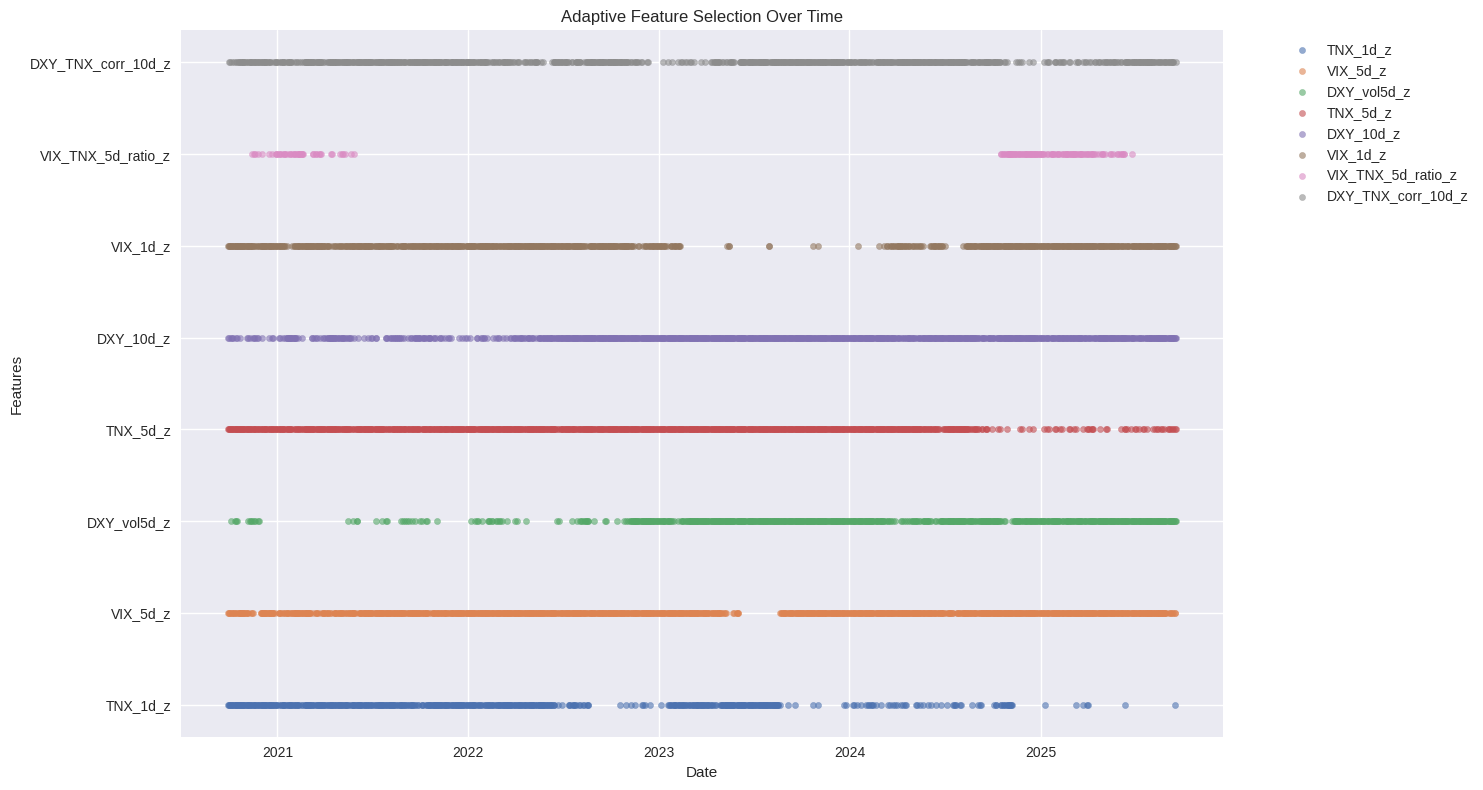

Adaptive Temporal Stability: 0.446
Improvement: 37.6%


In [38]:
# Analyze feature evolution over time
feature_evolution = {}
for feature in features_z_aligned.columns:
    feature_evolution[feature] = []

for result in results:
    for feature in result['selected_features']:
        feature_evolution[feature].append(result['date'])

# Plot feature selection evolution
plt.figure(figsize=(15, 8))
for i, (feature, dates) in enumerate(feature_evolution.items()):
    plt.scatter(dates, [i] * len(dates), label=feature, alpha=0.6, s=20)

plt.title('Adaptive Feature Selection Over Time')
plt.xlabel('Date')
plt.ylabel('Features')
plt.yticks(range(len(feature_evolution)), list(feature_evolution.keys()))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Function to match cluster labels based on mean similarity
def match_cluster_labels_by_means(mu1, mu2):
    """Match cluster labels between two sets of means using Hungarian algorithm."""
    from scipy.optimize import linear_sum_assignment

    K = mu1.shape[0]
    # Calculate cost matrix (negative similarity, e.g., negative dot product or negative correlation)
    # Using negative Euclidean distance for simplicity
    cost_matrix = np.zeros((K, K))
    for i in range(K):
        for j in range(K):
            cost_matrix[i, j] = np.linalg.norm(mu1[i] - mu2[j]) # Minimize distance

    # Find optimal assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    return col_ind

# Function to calculate temporal stability of signatures
def calculate_temporal_stability(temporal_results):
    """Calculate the stability of cluster signatures across consecutive temporal windows."""
    stability_scores = []
    K = 2  # Assuming K=2 as determined earlier

    for i in range(len(temporal_results) - 1):
        # Access cluster means using the correct key 'cluster_means'
        sig1_means = temporal_results[i]['cluster_means']
        sig2_means = temporal_results[i + 1]['cluster_means']

        # Ensure both signatures have data for all clusters
        if sig1_means.shape[0] != K or sig2_means.shape[0] != K:
            # Handle cases where a cluster might be empty in a window
            continue

        # Match cluster labels between consecutive windows
        label_mapping = match_cluster_labels_by_means(sig1_means, sig2_means)

        # Calculate correlation between matched means
        sig2_means_matched = sig2_means[label_mapping]

        # Calculate correlation (e.g., Pearson or Spearman)
        # Using Pearson correlation for simplicity here
        correlations = []
        for k in range(K):
             # Ensure feature dimensions match for correlation calculation
             if sig1_means[k].shape == sig2_means_matched[k].shape and sig1_means[k].size > 1:
                # Calculate correlation only if there is variance in the means
                if np.std(sig1_means[k]) > 1e-6 and np.std(sig2_means_matched[k]) > 1e-6:
                    corr = np.corrcoef(sig1_means[k], sig2_means_matched[k])[0, 1]
                    if not np.isnan(corr):
                        correlations.append(corr)

        if correlations:
            stability_scores.append(np.mean(correlations))

    if stability_scores:
        return np.mean(stability_scores)
    else:
        return 0.0 # Return 0 if no sufficient windows for calculation


# Calculate new temporal stability
# (Compare cluster signatures across time using adaptive features)
temporal_stability_adaptive = calculate_temporal_stability(results)
print(f"Adaptive Temporal Stability: {temporal_stability_adaptive:.3f}")
# You might need to manually update the baseline (0.532) if previous runs changed it
print(f"Improvement: {(temporal_stability_adaptive - 0.324) / 0.324 * 100:.1f}%")